In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

'''
None || 20000 || 100000
'''
nb = None
nb_trains = nb
nb_valids = nb
nb_tests = nb

N_past = 10

In [63]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [64]:
cd drive/MyDrive/Projects/JPX_Tokyo_Stock/JPX_stock_2022/working

[Errno 2] No such file or directory: 'drive/MyDrive/Projects/JPX_Tokyo_Stock/JPX_stock_2022/working'
/content/drive/MyDrive/Projects/JPX_Tokyo_Stock/JPX_stock_2022/working


In [65]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
import optuna
from data_utils import *

#### Load Data

In [67]:
train_df = pd.read_csv('../__input__/2_FeatureEngineering/train_df.csv', parse_dates=['Date'], nrows = nb_trains)
valid_df = pd.read_csv('../__input__/2_FeatureEngineering/valid_df.csv', parse_dates=['Date'], nrows = nb_trains)
test_df = pd.read_csv('../__input__/2_FeatureEngineering/test_df.csv', parse_dates=['Date'], nrows = nb_trains)

In [68]:
mini_train_DP = pd.read_csv('../__input__/1_DataPreprocessing/mini_train.csv', parse_dates=['Date'], nrows = None)
mini_train_FE = pd.read_csv('../__input__/2_FeatureEngineering/mini_train.csv', parse_dates=['Date'], nrows = None)

In [69]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1843182 entries, 0 to 1843181
Data columns (total 64 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Date              datetime64[ns]
 1   SecuritiesCode    int64         
 2   ExpectedDividend  float64       
 3   AdjustmentFactor  float64       
 4   SupervisionFlag   bool          
 5   Volume            float64       
 6   Close             float64       
 7   Target            float64       
 8   CloseT1           float64       
 9   CloseT2           float64       
 10  Range_HL          float64       
 11  Range_OC          float64       
 12  dayofyear         int64         
 13  dayofweek         int64         
 14  week              int64         
 15  is_month_end      bool          
 16  is_month_start    bool          
 17  is_year_end       bool          
 18  is_year_start     bool          
 19  Year              int64         
 20  Month             int64         
 21  Day     

In [70]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232663 entries, 0 to 232662
Data columns (total 64 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              232663 non-null  datetime64[ns]
 1   SecuritiesCode    232663 non-null  int64         
 2   ExpectedDividend  232663 non-null  float64       
 3   AdjustmentFactor  232663 non-null  float64       
 4   SupervisionFlag   232663 non-null  bool          
 5   Volume            232663 non-null  float64       
 6   Close             232663 non-null  float64       
 7   Target            232663 non-null  float64       
 8   CloseT1           232663 non-null  float64       
 9   CloseT2           232663 non-null  float64       
 10  Range_HL          232663 non-null  float64       
 11  Range_OC          232663 non-null  float64       
 12  dayofyear         232663 non-null  int64         
 13  dayofweek         232663 non-null  int64         
 14  week

In [71]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198663 entries, 0 to 198662
Data columns (total 64 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              198663 non-null  datetime64[ns]
 1   SecuritiesCode    198663 non-null  int64         
 2   ExpectedDividend  198663 non-null  float64       
 3   AdjustmentFactor  198663 non-null  float64       
 4   SupervisionFlag   198663 non-null  bool          
 5   Volume            198663 non-null  float64       
 6   Close             198663 non-null  float64       
 7   Target            198663 non-null  float64       
 8   CloseT1           198663 non-null  float64       
 9   CloseT2           198663 non-null  float64       
 10  Range_HL          198663 non-null  float64       
 11  Range_OC          198663 non-null  float64       
 12  dayofyear         198663 non-null  int64         
 13  dayofweek         198663 non-null  int64         
 14  week

### Calc Scores

In [72]:
def calc_spread_return_per_day(df, portfolio_size: int = 200, toprank_weight_ratio: float = 2):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): spread return
    """
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf

def add_rank(df: pd.DataFrame, y_pred):
    df["Pred"] = y_pred
    df["Rank"] = df.groupby("Date")["Pred"].rank(ascending=False, method="first") - 1 
    df = df.drop("Pred", axis= 1)
    return df

In [73]:
def calc_score(df: pd.DataFrame, y_pred: pd.DataFrame, y_true: pd.DataFrame, render_info= True):
    feature_df = df.copy()
    feature_df = add_rank(feature_df, y_pred)
    feature_df['Target'] = y_true
    score, buf = calc_spread_return_sharpe(feature_df)
    if render_info:
        print(f'score -> {score}\nmean -> {buf.mean()}\nstd -> {buf.std()}')
    del feature_df
    return score

In [74]:
calc_score(test_df, test_df["Target"], test_df["Target"])

score -> 4.7366694709759
mean -> 15.115996128121251
std -> 3.1912710440838277


4.7366694709759

#### Cross Validation

In [75]:
list_code = train_df['SecuritiesCode'].unique()
list_code

array([1301, 1332, 1333, ..., 4168, 7342, 4169])

In [76]:
len(list_code)

2000

In [77]:
# np.random.shuffle(list_code)
# list_code

# K_code_set = list(list_code.reshape((50, 40)))
# pd.DataFrame(
#     np.array(K_code_set), 
#     columns= ['Code_' + str(i) for i in range(len(K_code_set[0]))]
# ).to_csv('./K_code_set.csv', index= False)
# K_code_set

In [78]:
K_code_set = pd.read_csv('./K_code_set.csv')
K_code_set

,Code_0,Code_1,Code_2,Code_3,Code_4,Code_5,Code_6,Code_7,Code_8,Code_9,...,Code_30,Code_31,Code_32,Code_33,Code_34,Code_35,Code_36,Code_37,Code_38,Code_39
0,4044,7636,2220,5008,4435,8750,4324,5406,2217,6963,...,7105,7294,5101,9850,7962,4768,4595,6817,8844,7860
1,4350,2130,9279,4365,3183,8864,3288,9661,7931,4971,...,9824,7048,7229,3141,1821,9505,5821,8078,6448,8304
2,6834,7298,9601,7840,3377,5261,2742,9009,9028,6200,...,4538,4826,4078,7292,2353,9468,6143,6565,6966,8291
3,5949,6444,3402,9037,4212,8098,8056,8550,6890,2004,...,8163,7220,7342,5411,3663,4410,8890,2127,2987,6954
4,3191,9744,8337,4554,8137,7943,3903,4471,6517,7180,...,4547,5909,2587,1925,4182,2374,7912,8697,9509,6727
5,4503,8923,1413,6369,2767,4185,7613,6651,3105,2802,...,3593,5970,4312,2471,7752,6918,3360,6925,7856,9042
6,1518,2925,2676,8130,7990,6440,8367,2809,9658,7500,...,9081,4658,2208,4114,3762,3649,7181,8341,5440,6463
7,6999,8086,6125,6904,8739,6349,6875,2594,4781,8151,...,6412,2669,2226,7339,2307,5401,1898,3784,1879,3193
8,4521,5757,9856,9119,7730,5410,4687,7717,5711,6755,...,4563,6407,6538,9046,9414,7809,7779,4540,2590,4390
9,6882,7734,9787,9006,3116,2573,3798,6845,3064,6268,...,4714,6590,9232,7238,6462,3291,6616,4220,6902,4582


In [79]:
K_code_set = list(np.array(K_code_set))
K_code_set

[array([4044, 7636, 2220, 5008, 4435, 8750, 4324, 5406, 2217, 6963, 7906,
        6370, 1381, 6199, 9304, 6028, 7476, 9301, 7718, 2790, 7420, 3415,
        2378, 5357, 5902, 4118, 4666, 5706, 9076, 6473, 7105, 7294, 5101,
        9850, 7962, 4768, 4595, 6817, 8844, 7860]),
 array([4350, 2130, 9279, 4365, 3183, 8864, 3288, 9661, 7931, 4971, 6958,
        8366, 2932, 2715, 7240, 2805, 7011, 9401, 7203, 9506, 3088, 3228,
        2922, 6508, 1377, 9687, 9945, 8050, 8399, 2531, 9824, 7048, 7229,
        3141, 1821, 9505, 5821, 8078, 6448, 8304]),
 array([6834, 7298, 9601, 7840, 3377, 5261, 2742, 9009, 9028, 6200, 1926,
        8002, 2432, 6367, 4452, 2148, 7749, 2317, 9684, 7261, 9989, 3771,
        8168, 6612, 2053, 8361, 2292, 4368, 8698, 5463, 4538, 4826, 4078,
        7292, 2353, 9468, 6143, 6565, 6966, 8291]),
 array([5949, 6444, 3402, 9037, 4212, 8098, 8056, 8550, 6890, 2004, 3916,
        9324, 9450, 4481, 2612, 9613, 9962, 8558, 9739, 2491, 9621, 4716,
        6326, 8508, 3539, 6702

In [80]:
def find_datapoints_in_list(list_code, df: pd.DataFrame):
    return df[df['SecuritiesCode'].isin(list_code)].reset_index(drop= True)

In [81]:
find_datapoints_in_list(K_code_set[1], train_df)

,Date,SecuritiesCode,ExpectedDividend,AdjustmentFactor,SupervisionFlag,Volume,Close,Target,CloseT1,CloseT2,...,Close_lags_9,Range_HL_lags_9,Range_OC_lags_9,Volume_lags_9,Close_lags_10,Range_HL_lags_10,Range_OC_lags_10,Volume_lags_10,Close_mean,Close_std
0,2017-01-23,1377,-1.0,1.0,False,11.550221,-0.771175,0.001541,-1.074136,-0.973149,...,0.642646,1.009872,-0.100987,12.167851,0.642646,1.615794,-1.211846,11.923710,3298.181818,49.511248
1,2017-01-23,1821,-1.0,1.0,False,14.845023,-2.011823,0.008264,-1.320259,-0.628695,...,0.754434,2.766256,0.691564,15.772516,1.445998,2.074692,-1.383128,15.629651,122.909091,1.445998
2,2017-01-23,2130,-1.0,1.0,False,13.083207,0.998828,0.022047,0.804120,1.193536,...,0.776304,0.723202,-0.361601,13.382417,-2.672813,0.500678,-0.139077,11.779129,606.090909,35.951230
3,2017-01-23,2531,-1.0,1.0,False,13.467937,-1.339554,-0.001972,-1.382389,-1.468058,...,1.059182,1.199368,0.813857,13.381492,1.958708,0.771022,-0.342677,13.646974,1046.272727,23.345624
4,2017-01-23,2715,-1.0,1.0,False,9.116030,-0.487269,0.003041,-0.780040,-0.644915,...,-0.689957,0.788229,-0.495458,10.034516,-2.604228,1.508896,-1.351250,10.146434,2007.636364,44.403317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35588,2021-05-27,9506,-1.0,1.0,False,15.205498,-1.858558,-0.007804,-1.538404,-1.858558,...,1.068567,0.548836,-0.045736,14.319916,0.839885,0.914727,0.503100,13.981872,930.636364,21.864458
35589,2021-05-27,9661,-1.0,1.0,False,6.802395,0.630481,0.000000,0.363739,0.363739,...,0.096997,0.533484,0.000000,5.991465,-0.436487,1.600453,0.533484,7.649693,4818.181818,18.744696
35590,2021-05-27,9687,-1.0,1.0,False,6.396930,-0.509971,0.004944,-0.284683,-0.036865,...,0.886817,0.878625,-0.450577,6.802395,1.314865,0.382990,-0.360461,6.907755,2237.636364,44.387549
35591,2021-05-27,9824,-1.0,1.0,False,8.987197,-1.788679,0.022936,0.137005,1.392886,...,1.225435,2.428036,-1.088430,9.230143,-1.035150,2.260586,0.920979,9.358760,3261.818182,59.719039


In [82]:
K_train = []

In [83]:
for code_set in K_code_set:
    K_train.append(find_datapoints_in_list(code_set, train_df))

In [84]:
len(K_train), [len(K_train[i]) for i in range(len(K_train))]

(50,
 [37833,
  35593,
  37056,
  35726,
  38360,
  38270,
  36286,
  36561,
  36886,
  38342,
  37351,
  36229,
  36193,
  34949,
  37393,
  34659,
  36376,
  37236,
  35994,
  36142,
  36083,
  36961,
  37811,
  35430,
  37086,
  37138,
  35303,
  36231,
  36509,
  35864,
  37115,
  36546,
  37865,
  37137,
  35649,
  37369,
  38184,
  38121,
  36922,
  36759,
  38336,
  37733,
  37085,
  38238,
  37403,
  37696,
  37553,
  35573,
  36704,
  37343])

In [85]:
featureCols = train_df.drop(["Target", "CloseT1", "CloseT2"], axis = 1).columns
featureCols

Index(['Date', 'SecuritiesCode', 'ExpectedDividend', 'AdjustmentFactor',
       'SupervisionFlag', 'Volume', 'Close', 'Range_HL', 'Range_OC',
       'dayofyear', 'dayofweek', 'week', 'is_month_end', 'is_month_start',
       'is_year_end', 'is_year_start', 'Year', 'Month', 'Day', 'Close_lags_1',
       'Range_HL_lags_1', 'Range_OC_lags_1', 'Volume_lags_1', 'Close_lags_2',
       'Range_HL_lags_2', 'Range_OC_lags_2', 'Volume_lags_2', 'Close_lags_3',
       'Range_HL_lags_3', 'Range_OC_lags_3', 'Volume_lags_3', 'Close_lags_4',
       'Range_HL_lags_4', 'Range_OC_lags_4', 'Volume_lags_4', 'Close_lags_5',
       'Range_HL_lags_5', 'Range_OC_lags_5', 'Volume_lags_5', 'Close_lags_6',
       'Range_HL_lags_6', 'Range_OC_lags_6', 'Volume_lags_6', 'Close_lags_7',
       'Range_HL_lags_7', 'Range_OC_lags_7', 'Volume_lags_7', 'Close_lags_8',
       'Range_HL_lags_8', 'Range_OC_lags_8', 'Volume_lags_8', 'Close_lags_9',
       'Range_HL_lags_9', 'Range_OC_lags_9', 'Volume_lags_9', 'Close_lags_10',
 

In [86]:
X_train = train_df[featureCols]
X_train["Date"] = X_train["Date"].astype(str)
y_train = train_df["Target"]

X_valid = valid_df[featureCols]
X_valid["Date"] = X_valid["Date"].astype(str)
y_valid = valid_df["Target"]

X_test = test_df[featureCols]
X_test["Date"] = X_test["Date"].astype(str)
yTest_true = test_df["Target"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [87]:
calc_score(X_test, yTest_true, yTest_true)

score -> 4.7366694709759
mean -> 15.115996128121251
std -> 3.1912710440838277


4.7366694709759

#### Optuna tuning

In [ ]:
x_train_optuna = pd.DataFrame()
y_train_optuna = pd.DataFrame()
x_eval_optuna = X_valid
x_eval_not_date = X_valid.drop("Date", axis = 1)
y_eval_optuna = y_valid

In [ ]:
model = xgb.XGBRegressor()

In [ ]:
def objective(
    trial,
    random_state=22,
    n_jobs=-1,
):
    # XGBoost parameters
    params = {
        'tree_method':'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 5, 10) * 100,
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_loguniform("subsample", 0.6, 0.8),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
        "seed": random_state,
        "n_jobs": n_jobs,
        "early_stopping_rounds": 50,
        "eval_metric": "rmse"
        
    }

    global model
    model = xgb.XGBRegressor(**params) 

    model.fit(
        x_train_optuna,
        y_train_optuna,
        eval_set=[(x_eval_not_date, y_eval_optuna)],
        verbose=0,
    )
    y_pred = pd.DataFrame(model.predict(x_eval_not_date), columns =['Target'])
    return calc_score(x_eval_optuna, y_pred, y_eval_optuna, render_info= False)

In [ ]:
study_set = []
feature_important_list = pd.DataFrame(columns= x_train_optuna.columns)
feature_important_list

""


In [ ]:
for idx, train_set in enumerate(K_train):
    x_train_optuna = train_set[featureCols].drop("Date", axis = 1)
    y_train_optuna = train_set["Target"]

    print("set " + str(idx) + "_th")
    study_set.append(optuna.create_study(direction='maximize'))
    study_set[idx].optimize(objective, n_trials=10, gc_after_trial=True)

    feature_important_list = feature_important_list.append(pd.DataFrame(model.feature_importances_.reshape(1, -1), columns= x_train_optuna.columns))


[I 2022-07-20 01:08:10,793] A new study created in memory with name: no-name-fc80ae7d-bd24-4eb2-b5f6-815b301c8c69


set 0_th


[I 2022-07-20 01:08:19,203] Trial 0 finished with value: 0.08395696981250644 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.03420322572898663, 'colsample_bytree': 0.2445875951247389, 'subsample': 0.7782290041702004, 'alpha': 3.810623683055292, 'lambda': 0.0005209526199595786, 'min_child_weight': 13.02732528140621}. Best is trial 0 with value: 0.08395696981250644.
[I 2022-07-20 01:08:26,539] Trial 1 finished with value: 0.04784689515733381 and parameters: {'n_estimators': 6, 'max_depth': 6, 'learning_rate': 0.01254742949459158, 'colsample_bytree': 0.25959940287657546, 'subsample': 0.6340951870253675, 'alpha': 7.627917916339161, 'lambda': 0.0022216749487223354, 'min_child_weight': 20.667975527730356}. Best is trial 0 with value: 0.08395696981250644.
[I 2022-07-20 01:08:39,079] Trial 2 finished with value: -0.016089339973392826 and parameters: {'n_estimators': 6, 'max_depth': 12, 'learning_rate': 0.026742329275279187, 'colsample_bytree': 0.27916596803463783, 'subsa

set 1_th


[I 2022-07-20 01:10:14,369] Trial 0 finished with value: 0.06044376669379744 and parameters: {'n_estimators': 6, 'max_depth': 8, 'learning_rate': 0.025723510757044696, 'colsample_bytree': 0.26665236412648113, 'subsample': 0.6368299946651803, 'alpha': 1.059294471116049, 'lambda': 4.837425354504779e-08, 'min_child_weight': 49.616222298846026}. Best is trial 0 with value: 0.06044376669379744.
[I 2022-07-20 01:10:46,473] Trial 1 finished with value: 0.03208471507903914 and parameters: {'n_estimators': 9, 'max_depth': 16, 'learning_rate': 0.013842939050830998, 'colsample_bytree': 0.36626779721903496, 'subsample': 0.7251271973821406, 'alpha': 0.3452431820146384, 'lambda': 2.4427366839505725e-07, 'min_child_weight': 28.025637597105764}. Best is trial 0 with value: 0.06044376669379744.
[I 2022-07-20 01:10:58,270] Trial 2 finished with value: 0.09318661618040716 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.025785525448902866, 'colsample_bytree': 0.44638162647290214, '

set 2_th


[I 2022-07-20 01:12:21,547] Trial 0 finished with value: -0.0525857930448351 and parameters: {'n_estimators': 6, 'max_depth': 9, 'learning_rate': 0.013259726194221251, 'colsample_bytree': 0.4746382666863524, 'subsample': 0.6472713928887638, 'alpha': 3.298849697049119, 'lambda': 0.00012438876456625996, 'min_child_weight': 380.1994987429561}. Best is trial 0 with value: -0.0525857930448351.
[I 2022-07-20 01:12:43,414] Trial 1 finished with value: 0.1381855952231578 and parameters: {'n_estimators': 9, 'max_depth': 14, 'learning_rate': 0.005535564150001274, 'colsample_bytree': 0.4993125041340397, 'subsample': 0.6246365016201947, 'alpha': 0.01773125031798337, 'lambda': 1.9904188073347315e-06, 'min_child_weight': 20.73167925781274}. Best is trial 1 with value: 0.1381855952231578.
[I 2022-07-20 01:12:51,909] Trial 2 finished with value: 0.06499140424914994 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.026380571524127285, 'colsample_bytree': 0.22757524484199707, 'subsa

set 3_th


[I 2022-07-20 01:15:23,138] Trial 0 finished with value: -0.08417462736913434 and parameters: {'n_estimators': 9, 'max_depth': 19, 'learning_rate': 0.016024962970212994, 'colsample_bytree': 0.2866170260268635, 'subsample': 0.7784537958882309, 'alpha': 0.11441859536814536, 'lambda': 5.293326730210252e-06, 'min_child_weight': 784.0639124875729}. Best is trial 0 with value: -0.08417462736913434.
[I 2022-07-20 01:15:47,891] Trial 1 finished with value: 0.09483748896617929 and parameters: {'n_estimators': 6, 'max_depth': 17, 'learning_rate': 0.016811712335506747, 'colsample_bytree': 0.3901882225906215, 'subsample': 0.7293049336278432, 'alpha': 0.014657011481812759, 'lambda': 6.643191944787082e-07, 'min_child_weight': 24.049926134229047}. Best is trial 1 with value: 0.09483748896617929.
[I 2022-07-20 01:15:57,904] Trial 2 finished with value: -0.07284085261288317 and parameters: {'n_estimators': 7, 'max_depth': 18, 'learning_rate': 0.03968125356696974, 'colsample_bytree': 0.4436566170282893,

set 4_th


[I 2022-07-20 01:18:00,350] Trial 0 finished with value: 0.09337535268750863 and parameters: {'n_estimators': 6, 'max_depth': 11, 'learning_rate': 0.014095695171778866, 'colsample_bytree': 0.4506560264109279, 'subsample': 0.7173113004608779, 'alpha': 8.976892256826831, 'lambda': 0.0010776220385931494, 'min_child_weight': 65.31399954180307}. Best is trial 0 with value: 0.09337535268750863.
[I 2022-07-20 01:18:12,350] Trial 1 finished with value: 0.00028692778492762564 and parameters: {'n_estimators': 9, 'max_depth': 14, 'learning_rate': 0.007449415210885217, 'colsample_bytree': 0.20683802723510944, 'subsample': 0.7881751053991846, 'alpha': 1.1042202275518453, 'lambda': 0.0003436304162980999, 'min_child_weight': 282.5876885415118}. Best is trial 0 with value: 0.09337535268750863.
[I 2022-07-20 01:18:27,986] Trial 2 finished with value: 0.1387314575626242 and parameters: {'n_estimators': 10, 'max_depth': 14, 'learning_rate': 0.011970715953496663, 'colsample_bytree': 0.21027006582466298, '

set 5_th


[I 2022-07-20 01:20:01,109] Trial 0 finished with value: 0.08250998059350524 and parameters: {'n_estimators': 9, 'max_depth': 10, 'learning_rate': 0.00508559031043524, 'colsample_bytree': 0.40603992829623936, 'subsample': 0.7768660288056741, 'alpha': 0.015495674632259863, 'lambda': 8.718275952979696e-08, 'min_child_weight': 27.74581353697114}. Best is trial 0 with value: 0.08250998059350524.
[I 2022-07-20 01:20:28,633] Trial 1 finished with value: 0.18963627675059128 and parameters: {'n_estimators': 9, 'max_depth': 17, 'learning_rate': 0.023754582604935414, 'colsample_bytree': 0.5176657515290355, 'subsample': 0.7325873513884887, 'alpha': 0.2291142116037006, 'lambda': 4.360144991842247e-08, 'min_child_weight': 48.15569641491806}. Best is trial 1 with value: 0.18963627675059128.
[I 2022-07-20 01:20:38,113] Trial 2 finished with value: 0.10913500553522876 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.005737066065377076, 'colsample_bytree': 0.40546347326902527, 's

set 6_th


[I 2022-07-20 01:22:18,225] Trial 0 finished with value: 0.08194859257486331 and parameters: {'n_estimators': 7, 'max_depth': 18, 'learning_rate': 0.0463996958501043, 'colsample_bytree': 0.25347472773370133, 'subsample': 0.7107778887555191, 'alpha': 0.2448373106880657, 'lambda': 0.00046959101237112555, 'min_child_weight': 85.83103864566378}. Best is trial 0 with value: 0.08194859257486331.
[I 2022-07-20 01:22:27,239] Trial 1 finished with value: 0.14131074626526566 and parameters: {'n_estimators': 8, 'max_depth': 6, 'learning_rate': 0.03139694705951279, 'colsample_bytree': 0.21226244325124596, 'subsample': 0.6345136341136333, 'alpha': 0.5525557185543098, 'lambda': 6.814163698076067e-08, 'min_child_weight': 29.23205132782622}. Best is trial 1 with value: 0.14131074626526566.
[I 2022-07-20 01:22:42,938] Trial 2 finished with value: 0.09542592492144467 and parameters: {'n_estimators': 6, 'max_depth': 12, 'learning_rate': 0.032871433864771725, 'colsample_bytree': 0.317633244688491, 'subsam

set 7_th


[I 2022-07-20 01:24:52,751] Trial 0 finished with value: 0.04949158318687192 and parameters: {'n_estimators': 10, 'max_depth': 16, 'learning_rate': 0.035551170584917816, 'colsample_bytree': 0.381086001468864, 'subsample': 0.7342115905207299, 'alpha': 0.4232631925889318, 'lambda': 1.8695853179026105e-05, 'min_child_weight': 367.2929573066594}. Best is trial 0 with value: 0.04949158318687192.
[I 2022-07-20 01:25:37,160] Trial 1 finished with value: 0.30726890133507606 and parameters: {'n_estimators': 6, 'max_depth': 19, 'learning_rate': 0.03826243709465589, 'colsample_bytree': 0.20177795095168227, 'subsample': 0.772032412574069, 'alpha': 0.029698210637735402, 'lambda': 1.405639844073247e-06, 'min_child_weight': 12.947696247472901}. Best is trial 1 with value: 0.30726890133507606.
[I 2022-07-20 01:25:47,192] Trial 2 finished with value: 0.05711458917710322 and parameters: {'n_estimators': 7, 'max_depth': 15, 'learning_rate': 0.011927858770654276, 'colsample_bytree': 0.49527625167114064, '

set 8_th


[I 2022-07-20 01:27:26,379] Trial 0 finished with value: 0.14001214439257997 and parameters: {'n_estimators': 6, 'max_depth': 17, 'learning_rate': 0.025694598934373588, 'colsample_bytree': 0.24130084711178892, 'subsample': 0.6730493021286048, 'alpha': 0.42339922893072857, 'lambda': 0.00024316148728988762, 'min_child_weight': 16.333774160947723}. Best is trial 0 with value: 0.14001214439257997.
[I 2022-07-20 01:27:33,992] Trial 1 finished with value: 0.1578838662196765 and parameters: {'n_estimators': 5, 'max_depth': 8, 'learning_rate': 0.01544296183127218, 'colsample_bytree': 0.297022938455731, 'subsample': 0.7314815120859872, 'alpha': 7.86621458977655, 'lambda': 7.378393175130518e-07, 'min_child_weight': 19.479360506806945}. Best is trial 1 with value: 0.1578838662196765.
[I 2022-07-20 01:27:44,019] Trial 2 finished with value: 0.09884168261558626 and parameters: {'n_estimators': 8, 'max_depth': 8, 'learning_rate': 0.006833415396434974, 'colsample_bytree': 0.5102405062634758, 'subsamp

set 9_th


[I 2022-07-20 01:29:06,284] Trial 0 finished with value: 0.018160634157536784 and parameters: {'n_estimators': 7, 'max_depth': 13, 'learning_rate': 0.029190285139452543, 'colsample_bytree': 0.43710100204621755, 'subsample': 0.7394784321292621, 'alpha': 0.014693854502534425, 'lambda': 0.9351156568996454, 'min_child_weight': 126.6539131071394}. Best is trial 0 with value: 0.018160634157536784.
[I 2022-07-20 01:29:18,983] Trial 1 finished with value: 0.09434501874173137 and parameters: {'n_estimators': 10, 'max_depth': 8, 'learning_rate': 0.042367118597072706, 'colsample_bytree': 0.5689329162148099, 'subsample': 0.6354353857825491, 'alpha': 4.4426397321871915, 'lambda': 5.723548188003767e-05, 'min_child_weight': 58.1341843304372}. Best is trial 1 with value: 0.09434501874173137.
[I 2022-07-20 01:29:27,851] Trial 2 finished with value: -0.1525954481832666 and parameters: {'n_estimators': 6, 'max_depth': 17, 'learning_rate': 0.015916399744310552, 'colsample_bytree': 0.21104506467252054, 'su

set 10_th


[I 2022-07-20 01:31:07,738] Trial 0 finished with value: -0.013553859905370768 and parameters: {'n_estimators': 9, 'max_depth': 19, 'learning_rate': 0.043277192831312684, 'colsample_bytree': 0.22527038120134457, 'subsample': 0.7887604886521805, 'alpha': 2.2722463804411412, 'lambda': 1.0432701664636934, 'min_child_weight': 175.58510885078942}. Best is trial 0 with value: -0.013553859905370768.
[I 2022-07-20 01:31:29,297] Trial 1 finished with value: 0.07568513205563651 and parameters: {'n_estimators': 7, 'max_depth': 15, 'learning_rate': 0.006313063153313224, 'colsample_bytree': 0.3684379243770339, 'subsample': 0.6306756196945683, 'alpha': 9.895112857177276, 'lambda': 1.4378964141923805e-05, 'min_child_weight': 14.788220929166927}. Best is trial 1 with value: 0.07568513205563651.
[I 2022-07-20 01:31:46,510] Trial 2 finished with value: 0.025089263936307095 and parameters: {'n_estimators': 5, 'max_depth': 16, 'learning_rate': 0.009949581810581313, 'colsample_bytree': 0.4513203174127627, 

set 11_th


[I 2022-07-20 01:33:04,690] Trial 0 finished with value: -0.07936401979457942 and parameters: {'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.03518284601549167, 'colsample_bytree': 0.23636994733703476, 'subsample': 0.6795649098599272, 'alpha': 0.05833093678075414, 'lambda': 2.31227417459132e-05, 'min_child_weight': 880.8063266423633}. Best is trial 0 with value: -0.07936401979457942.
[I 2022-07-20 01:33:12,490] Trial 1 finished with value: -0.07558275939860475 and parameters: {'n_estimators': 7, 'max_depth': 6, 'learning_rate': 0.016376114619287122, 'colsample_bytree': 0.30385936370123623, 'subsample': 0.6161128755935397, 'alpha': 0.01802204799421834, 'lambda': 0.05043060167621446, 'min_child_weight': 475.98534306723644}. Best is trial 1 with value: -0.07558275939860475.
[I 2022-07-20 01:33:26,816] Trial 2 finished with value: 0.06492112827353566 and parameters: {'n_estimators': 7, 'max_depth': 12, 'learning_rate': 0.009027904546137538, 'colsample_bytree': 0.4624512761166123, '

set 12_th


[I 2022-07-20 01:35:04,534] Trial 0 finished with value: 0.1113585350297033 and parameters: {'n_estimators': 8, 'max_depth': 11, 'learning_rate': 0.01748145161371887, 'colsample_bytree': 0.27295709389784534, 'subsample': 0.7220284741566263, 'alpha': 0.2555039371500659, 'lambda': 0.007451794058929741, 'min_child_weight': 69.95813470974703}. Best is trial 0 with value: 0.1113585350297033.
[I 2022-07-20 01:35:14,139] Trial 1 finished with value: -0.034542700992082676 and parameters: {'n_estimators': 8, 'max_depth': 9, 'learning_rate': 0.0071156400393344015, 'colsample_bytree': 0.3767528632135029, 'subsample': 0.6573711823383593, 'alpha': 5.387572829772566, 'lambda': 0.003561109074870738, 'min_child_weight': 215.01269200752182}. Best is trial 0 with value: 0.1113585350297033.
[I 2022-07-20 01:35:47,487] Trial 2 finished with value: 0.07915980543612795 and parameters: {'n_estimators': 7, 'max_depth': 20, 'learning_rate': 0.01668938133571338, 'colsample_bytree': 0.37716184041274914, 'subsamp

set 13_th


[I 2022-07-20 01:37:29,418] Trial 0 finished with value: 0.06010879354675972 and parameters: {'n_estimators': 10, 'max_depth': 19, 'learning_rate': 0.018192706266410914, 'colsample_bytree': 0.48132132267919453, 'subsample': 0.6152663985846343, 'alpha': 0.028257848472839627, 'lambda': 7.542682812038108e-08, 'min_child_weight': 26.906361457349078}. Best is trial 0 with value: 0.06010879354675972.
[I 2022-07-20 01:37:36,101] Trial 1 finished with value: -0.04379779667336297 and parameters: {'n_estimators': 5, 'max_depth': 8, 'learning_rate': 0.012477576332939501, 'colsample_bytree': 0.35202085623249835, 'subsample': 0.6349779035663439, 'alpha': 0.012153706179206346, 'lambda': 0.47325108565401397, 'min_child_weight': 499.49869802966595}. Best is trial 0 with value: 0.06010879354675972.
[I 2022-07-20 01:37:45,030] Trial 2 finished with value: -0.008862577428246029 and parameters: {'n_estimators': 8, 'max_depth': 8, 'learning_rate': 0.020905939696487304, 'colsample_bytree': 0.233443625102719

set 14_th


[I 2022-07-20 01:39:19,774] Trial 0 finished with value: 0.09957455291281023 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.006423874177878881, 'colsample_bytree': 0.3079923669356051, 'subsample': 0.6992314865603707, 'alpha': 0.12097908000837206, 'lambda': 0.10139977437595257, 'min_child_weight': 75.80963533136011}. Best is trial 0 with value: 0.09957455291281023.
[I 2022-07-20 01:40:01,462] Trial 1 finished with value: 0.10530476675837554 and parameters: {'n_estimators': 8, 'max_depth': 17, 'learning_rate': 0.0471857127799723, 'colsample_bytree': 0.39110644093760055, 'subsample': 0.7044198268501876, 'alpha': 1.1135000675966376, 'lambda': 1.507179101119492e-08, 'min_child_weight': 19.205088267159816}. Best is trial 1 with value: 0.10530476675837554.
[I 2022-07-20 01:40:30,667] Trial 2 finished with value: 0.08502532123182484 and parameters: {'n_estimators': 9, 'max_depth': 14, 'learning_rate': 0.021139086562575737, 'colsample_bytree': 0.20886651040613505, 'subsa

set 15_th


[I 2022-07-20 01:42:17,522] Trial 0 finished with value: -0.03762174567733245 and parameters: {'n_estimators': 8, 'max_depth': 12, 'learning_rate': 0.04228273632643962, 'colsample_bytree': 0.38540644899251214, 'subsample': 0.7232960798734618, 'alpha': 4.60772313382229, 'lambda': 0.0001953751581984552, 'min_child_weight': 830.2293656092395}. Best is trial 0 with value: -0.03762174567733245.
[I 2022-07-20 01:42:32,474] Trial 1 finished with value: 0.026523390046276553 and parameters: {'n_estimators': 10, 'max_depth': 13, 'learning_rate': 0.04609649645875682, 'colsample_bytree': 0.47857641195259, 'subsample': 0.6529967163289861, 'alpha': 0.01265898492076846, 'lambda': 0.04498042675865696, 'min_child_weight': 158.7224346425114}. Best is trial 1 with value: 0.026523390046276553.
[I 2022-07-20 01:43:05,214] Trial 2 finished with value: 0.05886209212319591 and parameters: {'n_estimators': 8, 'max_depth': 19, 'learning_rate': 0.010481957311536718, 'colsample_bytree': 0.47027329852433536, 'subs

set 16_th


[I 2022-07-20 01:45:02,809] Trial 0 finished with value: 0.04970266317334497 and parameters: {'n_estimators': 8, 'max_depth': 4, 'learning_rate': 0.005271893773515982, 'colsample_bytree': 0.45205431848332595, 'subsample': 0.795294630448921, 'alpha': 0.19997460316422214, 'lambda': 1.0630679990082722e-06, 'min_child_weight': 210.1097884915279}. Best is trial 0 with value: 0.04970266317334497.
[I 2022-07-20 01:45:11,619] Trial 1 finished with value: 0.05358305332198303 and parameters: {'n_estimators': 7, 'max_depth': 8, 'learning_rate': 0.012882163376961556, 'colsample_bytree': 0.22929424624728853, 'subsample': 0.6537898277193528, 'alpha': 7.446475130186857, 'lambda': 0.012801601183077617, 'min_child_weight': 34.90706391716829}. Best is trial 1 with value: 0.05358305332198303.
[I 2022-07-20 01:45:41,754] Trial 2 finished with value: 0.08109610162827484 and parameters: {'n_estimators': 7, 'max_depth': 19, 'learning_rate': 0.01266026613642964, 'colsample_bytree': 0.40756784593877615, 'subsa

set 17_th


[I 2022-07-20 01:47:44,732] Trial 0 finished with value: 0.011452973944146108 and parameters: {'n_estimators': 9, 'max_depth': 11, 'learning_rate': 0.009897894122437096, 'colsample_bytree': 0.587194284969913, 'subsample': 0.6496121857521738, 'alpha': 0.019005932430448253, 'lambda': 0.0874537252759116, 'min_child_weight': 289.62620364503636}. Best is trial 0 with value: 0.011452973944146108.
[I 2022-07-20 01:47:54,737] Trial 1 finished with value: -0.027856487990745506 and parameters: {'n_estimators': 7, 'max_depth': 16, 'learning_rate': 0.04841878012016716, 'colsample_bytree': 0.4970648278037957, 'subsample': 0.774043078712063, 'alpha': 0.024936098857950784, 'lambda': 0.12909509893896254, 'min_child_weight': 507.84155548420375}. Best is trial 0 with value: 0.011452973944146108.
[I 2022-07-20 01:48:06,549] Trial 2 finished with value: 0.0006231829065499006 and parameters: {'n_estimators': 8, 'max_depth': 19, 'learning_rate': 0.006191584406284916, 'colsample_bytree': 0.35791824130233496,

set 18_th


[I 2022-07-20 01:51:04,192] Trial 0 finished with value: 0.35039312049670995 and parameters: {'n_estimators': 10, 'max_depth': 16, 'learning_rate': 0.007037591067999936, 'colsample_bytree': 0.33894056348774354, 'subsample': 0.742301999027631, 'alpha': 0.01575860045636096, 'lambda': 3.687898996060163, 'min_child_weight': 30.867283934841517}. Best is trial 0 with value: 0.35039312049670995.
[I 2022-07-20 01:51:12,997] Trial 1 finished with value: 0.15069763730163954 and parameters: {'n_estimators': 6, 'max_depth': 19, 'learning_rate': 0.006095495419209074, 'colsample_bytree': 0.5565954599850736, 'subsample': 0.6577019200232767, 'alpha': 0.10177209911063789, 'lambda': 5.652361168080402e-06, 'min_child_weight': 720.8828705085966}. Best is trial 0 with value: 0.35039312049670995.
[I 2022-07-20 01:51:30,320] Trial 2 finished with value: 0.31438515393537625 and parameters: {'n_estimators': 7, 'max_depth': 12, 'learning_rate': 0.010961100502353912, 'colsample_bytree': 0.26380590758906464, 'sub

set 19_th


[I 2022-07-20 01:53:05,805] Trial 0 finished with value: 0.07169578248773786 and parameters: {'n_estimators': 7, 'max_depth': 9, 'learning_rate': 0.026204943731320502, 'colsample_bytree': 0.27880766021370906, 'subsample': 0.7594570504173839, 'alpha': 0.027268877801355687, 'lambda': 0.0006843395221443297, 'min_child_weight': 458.65917237829177}. Best is trial 0 with value: 0.07169578248773786.
[I 2022-07-20 01:53:21,589] Trial 1 finished with value: 0.05460430218368902 and parameters: {'n_estimators': 8, 'max_depth': 11, 'learning_rate': 0.03201969933430907, 'colsample_bytree': 0.21510136776290117, 'subsample': 0.6581309382425143, 'alpha': 6.636012094194535, 'lambda': 0.0006216060552472288, 'min_child_weight': 29.84635146605136}. Best is trial 0 with value: 0.07169578248773786.
[I 2022-07-20 01:53:30,446] Trial 2 finished with value: 0.03409011560394296 and parameters: {'n_estimators': 7, 'max_depth': 12, 'learning_rate': 0.014911792399833115, 'colsample_bytree': 0.20148953367235278, 's

set 20_th


[I 2022-07-20 01:57:03,252] Trial 0 finished with value: 0.21374638253331585 and parameters: {'n_estimators': 5, 'max_depth': 15, 'learning_rate': 0.03568541476462778, 'colsample_bytree': 0.4690247093443825, 'subsample': 0.7977891405282213, 'alpha': 0.07191701414071174, 'lambda': 1.714660687825929e-05, 'min_child_weight': 16.41817565713273}. Best is trial 0 with value: 0.21374638253331585.
[I 2022-07-20 01:57:13,940] Trial 1 finished with value: -0.026004801362252118 and parameters: {'n_estimators': 9, 'max_depth': 12, 'learning_rate': 0.03235757981555176, 'colsample_bytree': 0.47607239257194717, 'subsample': 0.6843114489039452, 'alpha': 0.5978137387358627, 'lambda': 2.1214049480363414e-06, 'min_child_weight': 617.3657026152049}. Best is trial 0 with value: 0.21374638253331585.
[I 2022-07-20 01:57:21,816] Trial 2 finished with value: 0.002536088636671817 and parameters: {'n_estimators': 6, 'max_depth': 8, 'learning_rate': 0.030786218207707335, 'colsample_bytree': 0.36571775737500234, '

set 21_th


[I 2022-07-20 01:59:18,609] Trial 0 finished with value: 0.2549506022321567 and parameters: {'n_estimators': 8, 'max_depth': 15, 'learning_rate': 0.0054292945690332505, 'colsample_bytree': 0.3941418876255299, 'subsample': 0.7183643926644833, 'alpha': 3.6945277038852224, 'lambda': 0.14434969311751733, 'min_child_weight': 47.382058588033146}. Best is trial 0 with value: 0.2549506022321567.
[I 2022-07-20 01:59:29,034] Trial 1 finished with value: 0.30710245020913096 and parameters: {'n_estimators': 9, 'max_depth': 8, 'learning_rate': 0.005251250523143393, 'colsample_bytree': 0.2500803224187485, 'subsample': 0.7146760229588112, 'alpha': 5.9407808343755315, 'lambda': 1.4910713746990837e-06, 'min_child_weight': 31.196784068618324}. Best is trial 1 with value: 0.30710245020913096.
[I 2022-07-20 01:59:46,192] Trial 2 finished with value: 0.29055642124264813 and parameters: {'n_estimators': 5, 'max_depth': 13, 'learning_rate': 0.03221731013930899, 'colsample_bytree': 0.23494766522023694, 'subsa

set 22_th


[I 2022-07-20 02:01:34,148] Trial 0 finished with value: -0.0154462109058159 and parameters: {'n_estimators': 7, 'max_depth': 15, 'learning_rate': 0.02857175881521109, 'colsample_bytree': 0.3917425522108968, 'subsample': 0.7449888248194295, 'alpha': 0.9217103769677624, 'lambda': 1.3361079712432183e-06, 'min_child_weight': 433.49649284510025}. Best is trial 0 with value: -0.0154462109058159.
[I 2022-07-20 02:01:42,962] Trial 1 finished with value: -0.047886014945582846 and parameters: {'n_estimators': 6, 'max_depth': 18, 'learning_rate': 0.014735637879463062, 'colsample_bytree': 0.49643361012006676, 'subsample': 0.6008705986264326, 'alpha': 0.013530643733795344, 'lambda': 1.7681743495549134, 'min_child_weight': 493.6882788545126}. Best is trial 0 with value: -0.0154462109058159.
[I 2022-07-20 02:01:52,940] Trial 2 finished with value: 0.059562974543567064 and parameters: {'n_estimators': 9, 'max_depth': 11, 'learning_rate': 0.028845892422177822, 'colsample_bytree': 0.33787733119010355, 

set 23_th


[I 2022-07-20 02:03:21,486] Trial 0 finished with value: 0.11968756060112452 and parameters: {'n_estimators': 7, 'max_depth': 16, 'learning_rate': 0.006249169901175074, 'colsample_bytree': 0.20297079420049513, 'subsample': 0.618964812900807, 'alpha': 2.9977019265424674, 'lambda': 1.0801432832066567e-08, 'min_child_weight': 88.30362874742463}. Best is trial 0 with value: 0.11968756060112452.
[I 2022-07-20 02:03:34,327] Trial 1 finished with value: 0.032296674136765 and parameters: {'n_estimators': 6, 'max_depth': 20, 'learning_rate': 0.022723050449758156, 'colsample_bytree': 0.48758042999287793, 'subsample': 0.6259185743435994, 'alpha': 0.14694152198029495, 'lambda': 0.0016856877718547532, 'min_child_weight': 425.80226071969463}. Best is trial 0 with value: 0.11968756060112452.
[I 2022-07-20 02:03:48,123] Trial 2 finished with value: 0.08164734928374211 and parameters: {'n_estimators': 10, 'max_depth': 13, 'learning_rate': 0.02105820314478882, 'colsample_bytree': 0.34934795632071075, 's

set 24_th


[I 2022-07-20 02:05:07,478] Trial 0 finished with value: 0.009226314319026463 and parameters: {'n_estimators': 7, 'max_depth': 6, 'learning_rate': 0.0055309947053053, 'colsample_bytree': 0.5266564742001639, 'subsample': 0.7490055156713394, 'alpha': 4.792778736697438, 'lambda': 0.0004406240421022981, 'min_child_weight': 277.9702476122875}. Best is trial 0 with value: 0.009226314319026463.
[I 2022-07-20 02:05:18,447] Trial 1 finished with value: 0.042287570827418366 and parameters: {'n_estimators': 8, 'max_depth': 12, 'learning_rate': 0.02222880219559132, 'colsample_bytree': 0.3473299287749288, 'subsample': 0.7696379830427574, 'alpha': 0.08338146847661583, 'lambda': 0.23844497893928046, 'min_child_weight': 290.34343335870733}. Best is trial 1 with value: 0.042287570827418366.
[I 2022-07-20 02:05:37,383] Trial 2 finished with value: 0.104352627373166 and parameters: {'n_estimators': 7, 'max_depth': 20, 'learning_rate': 0.0073481670425071645, 'colsample_bytree': 0.47897192638721786, 'subsa

set 25_th


[I 2022-07-20 02:07:24,845] Trial 0 finished with value: -0.10933573300858886 and parameters: {'n_estimators': 6, 'max_depth': 20, 'learning_rate': 0.012783354485310448, 'colsample_bytree': 0.24586436053111876, 'subsample': 0.6313372264277468, 'alpha': 0.012042461955807179, 'lambda': 0.005360693114906968, 'min_child_weight': 354.0064594805324}. Best is trial 0 with value: -0.10933573300858886.
[I 2022-07-20 02:07:33,321] Trial 1 finished with value: 0.08998933118970427 and parameters: {'n_estimators': 5, 'max_depth': 14, 'learning_rate': 0.00955655625931018, 'colsample_bytree': 0.20030633723914412, 'subsample': 0.7798292158592461, 'alpha': 3.226409424412335, 'lambda': 0.0005119930245885713, 'min_child_weight': 138.31474921633625}. Best is trial 1 with value: 0.08998933118970427.
[I 2022-07-20 02:07:57,967] Trial 2 finished with value: -0.018180431590712007 and parameters: {'n_estimators': 5, 'max_depth': 16, 'learning_rate': 0.028886046435789115, 'colsample_bytree': 0.3580231041784194,

set 26_th


[I 2022-07-20 02:09:56,182] Trial 0 finished with value: 0.06668005318451155 and parameters: {'n_estimators': 7, 'max_depth': 11, 'learning_rate': 0.00928380377740142, 'colsample_bytree': 0.2442239527426738, 'subsample': 0.6142157851216891, 'alpha': 2.5637955366052414, 'lambda': 7.163820063343639e-05, 'min_child_weight': 68.53118940421602}. Best is trial 0 with value: 0.06668005318451155.
[I 2022-07-20 02:10:13,342] Trial 1 finished with value: 0.11812576001799359 and parameters: {'n_estimators': 10, 'max_depth': 12, 'learning_rate': 0.0179292946441918, 'colsample_bytree': 0.2925452886102314, 'subsample': 0.6877615429729167, 'alpha': 0.21221937500328816, 'lambda': 0.004672197235239577, 'min_child_weight': 48.10213952565652}. Best is trial 1 with value: 0.11812576001799359.
[I 2022-07-20 02:10:26,405] Trial 2 finished with value: 0.12671947329791922 and parameters: {'n_estimators': 9, 'max_depth': 9, 'learning_rate': 0.03738763666151371, 'colsample_bytree': 0.23733124587177137, 'subsamp

set 27_th


[I 2022-07-20 02:12:19,699] Trial 0 finished with value: 0.004840732496465279 and parameters: {'n_estimators': 5, 'max_depth': 20, 'learning_rate': 0.037604934333844015, 'colsample_bytree': 0.44440442480242154, 'subsample': 0.6420329808594112, 'alpha': 0.15700516351040825, 'lambda': 0.0001947254900157255, 'min_child_weight': 933.8260774662907}. Best is trial 0 with value: 0.004840732496465279.
[I 2022-07-20 02:12:37,092] Trial 1 finished with value: 0.1401781363845191 and parameters: {'n_estimators': 5, 'max_depth': 15, 'learning_rate': 0.048640025535893784, 'colsample_bytree': 0.20526246058741596, 'subsample': 0.7367577191836122, 'alpha': 0.01685992798007106, 'lambda': 0.08376980535212607, 'min_child_weight': 25.591820499869687}. Best is trial 1 with value: 0.1401781363845191.
[I 2022-07-20 02:12:47,083] Trial 2 finished with value: -0.02430538199247366 and parameters: {'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.02285585640177068, 'colsample_bytree': 0.23232524170751667, '

set 28_th


[I 2022-07-20 02:15:22,819] Trial 0 finished with value: -0.01561888882987763 and parameters: {'n_estimators': 9, 'max_depth': 19, 'learning_rate': 0.049520165382228136, 'colsample_bytree': 0.21605871526908074, 'subsample': 0.6161274944025878, 'alpha': 0.0188199840189039, 'lambda': 4.5971913657103605e-05, 'min_child_weight': 449.0330568539487}. Best is trial 0 with value: -0.01561888882987763.
[I 2022-07-20 02:16:01,113] Trial 1 finished with value: 0.18069934127884385 and parameters: {'n_estimators': 10, 'max_depth': 16, 'learning_rate': 0.019448691169712942, 'colsample_bytree': 0.4202189523711933, 'subsample': 0.6933995383219678, 'alpha': 0.05747189149265386, 'lambda': 2.0407749232533118e-06, 'min_child_weight': 21.163145030376768}. Best is trial 1 with value: 0.18069934127884385.
[I 2022-07-20 02:16:08,424] Trial 2 finished with value: 0.0976645636515549 and parameters: {'n_estimators': 7, 'max_depth': 4, 'learning_rate': 0.01827715198585029, 'colsample_bytree': 0.203355226480417, '

set 29_th


[I 2022-07-20 02:17:29,323] Trial 0 finished with value: 0.06089941036145078 and parameters: {'n_estimators': 8, 'max_depth': 4, 'learning_rate': 0.01605822642835879, 'colsample_bytree': 0.2586726677341382, 'subsample': 0.7570387087352692, 'alpha': 0.04604507047096872, 'lambda': 8.554247093114837, 'min_child_weight': 476.05714083966717}. Best is trial 0 with value: 0.06089941036145078.
[I 2022-07-20 02:17:37,165] Trial 1 finished with value: 0.0444359245690709 and parameters: {'n_estimators': 6, 'max_depth': 15, 'learning_rate': 0.0127430291729683, 'colsample_bytree': 0.259231034635434, 'subsample': 0.7302500646352423, 'alpha': 4.730823122146262, 'lambda': 4.3100687721682995e-07, 'min_child_weight': 573.2435867082613}. Best is trial 0 with value: 0.06089941036145078.
[I 2022-07-20 02:17:45,770] Trial 2 finished with value: 0.1257728894954278 and parameters: {'n_estimators': 8, 'max_depth': 6, 'learning_rate': 0.01392268369244632, 'colsample_bytree': 0.3285413594061029, 'subsample': 0.7

set 30_th


[I 2022-07-20 02:20:00,234] Trial 0 finished with value: 0.15249987150038882 and parameters: {'n_estimators': 9, 'max_depth': 12, 'learning_rate': 0.02390016342950768, 'colsample_bytree': 0.3868081341743602, 'subsample': 0.637651336738965, 'alpha': 1.5519315194658492, 'lambda': 0.0009679798819779883, 'min_child_weight': 20.006941470727728}. Best is trial 0 with value: 0.15249987150038882.
[I 2022-07-20 02:20:16,149] Trial 1 finished with value: 0.12256688895878246 and parameters: {'n_estimators': 10, 'max_depth': 15, 'learning_rate': 0.006507433892325047, 'colsample_bytree': 0.34325697150209783, 'subsample': 0.7877109154637277, 'alpha': 0.5059767997182959, 'lambda': 1.174972275600999e-06, 'min_child_weight': 158.7657576361975}. Best is trial 0 with value: 0.15249987150038882.
[I 2022-07-20 02:20:24,561] Trial 2 finished with value: 0.034772935387246316 and parameters: {'n_estimators': 8, 'max_depth': 6, 'learning_rate': 0.006563410679692372, 'colsample_bytree': 0.3243814596651401, 'sub

set 31_th


[I 2022-07-20 02:22:47,171] Trial 0 finished with value: 0.1278151662927011 and parameters: {'n_estimators': 6, 'max_depth': 19, 'learning_rate': 0.019850913313592337, 'colsample_bytree': 0.2008254850429954, 'subsample': 0.7173452243635661, 'alpha': 4.651525424902711, 'lambda': 2.1490402953160003e-08, 'min_child_weight': 30.945720791064772}. Best is trial 0 with value: 0.1278151662927011.
[I 2022-07-20 02:22:57,243] Trial 1 finished with value: 0.021841820431863255 and parameters: {'n_estimators': 10, 'max_depth': 8, 'learning_rate': 0.005815849404268856, 'colsample_bytree': 0.36291163626370404, 'subsample': 0.6039215521567787, 'alpha': 1.2397691956754744, 'lambda': 0.10642766370038914, 'min_child_weight': 569.8053404116952}. Best is trial 0 with value: 0.1278151662927011.
[I 2022-07-20 02:23:07,716] Trial 2 finished with value: 0.17066006852733007 and parameters: {'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.012139017761107726, 'colsample_bytree': 0.26460794986550684, 'subsa

set 32_th


[I 2022-07-20 02:26:24,383] Trial 0 finished with value: 0.22524088772216866 and parameters: {'n_estimators': 9, 'max_depth': 17, 'learning_rate': 0.046062032237698454, 'colsample_bytree': 0.5370705678116848, 'subsample': 0.7401397080865232, 'alpha': 0.024370152675257203, 'lambda': 3.0279938818583957e-06, 'min_child_weight': 11.676882069095493}. Best is trial 0 with value: 0.22524088772216866.
[I 2022-07-20 02:26:32,515] Trial 1 finished with value: 0.009324317102921137 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.00999887416545188, 'colsample_bytree': 0.5261288399720213, 'subsample': 0.6239824406994505, 'alpha': 6.693226237074385, 'lambda': 2.6027827940686086e-08, 'min_child_weight': 359.0353144884977}. Best is trial 0 with value: 0.22524088772216866.
[I 2022-07-20 02:26:46,031] Trial 2 finished with value: 0.15322207413848732 and parameters: {'n_estimators': 10, 'max_depth': 9, 'learning_rate': 0.03457208016343337, 'colsample_bytree': 0.261724090956185, 'sub

set 33_th


[I 2022-07-20 02:28:52,818] Trial 0 finished with value: 0.11955286849213435 and parameters: {'n_estimators': 10, 'max_depth': 4, 'learning_rate': 0.03298675434972062, 'colsample_bytree': 0.4631106310644549, 'subsample': 0.7662310500688885, 'alpha': 1.9246244189564277, 'lambda': 1.6668299285630008, 'min_child_weight': 25.065522834708222}. Best is trial 0 with value: 0.11955286849213435.
[I 2022-07-20 02:29:07,548] Trial 1 finished with value: 0.10215334918671895 and parameters: {'n_estimators': 5, 'max_depth': 17, 'learning_rate': 0.007844104578568316, 'colsample_bytree': 0.42327082778644165, 'subsample': 0.6907177596757167, 'alpha': 0.06517159633195119, 'lambda': 0.00016693361321260347, 'min_child_weight': 22.12220277090628}. Best is trial 0 with value: 0.11955286849213435.
[I 2022-07-20 02:29:19,844] Trial 2 finished with value: 0.04667878590849425 and parameters: {'n_estimators': 9, 'max_depth': 13, 'learning_rate': 0.0065695491425211035, 'colsample_bytree': 0.48041570334425976, 'su

set 34_th


[I 2022-07-20 02:30:57,299] Trial 0 finished with value: 0.030495124974456094 and parameters: {'n_estimators': 8, 'max_depth': 6, 'learning_rate': 0.014959780411733431, 'colsample_bytree': 0.20725243678988833, 'subsample': 0.7536737019744256, 'alpha': 0.0414347096558069, 'lambda': 0.10140050961622853, 'min_child_weight': 71.16740930095408}. Best is trial 0 with value: 0.030495124974456094.
[I 2022-07-20 02:31:04,032] Trial 1 finished with value: 0.04447744354963628 and parameters: {'n_estimators': 6, 'max_depth': 4, 'learning_rate': 0.035152818323711886, 'colsample_bytree': 0.23998615622555672, 'subsample': 0.6487189623847673, 'alpha': 0.2644792927874608, 'lambda': 0.9102915702680668, 'min_child_weight': 23.66963968447238}. Best is trial 1 with value: 0.04447744354963628.
[I 2022-07-20 02:31:13,188] Trial 2 finished with value: 0.04142818955952585 and parameters: {'n_estimators': 8, 'max_depth': 6, 'learning_rate': 0.04769514772025398, 'colsample_bytree': 0.3160546247616652, 'subsample

set 35_th


[I 2022-07-20 02:32:31,521] Trial 0 finished with value: 0.07538549211280778 and parameters: {'n_estimators': 5, 'max_depth': 18, 'learning_rate': 0.016259347824385786, 'colsample_bytree': 0.21934184567421725, 'subsample': 0.7602246701965217, 'alpha': 4.108114473012697, 'lambda': 0.006958947299959086, 'min_child_weight': 152.11718919879445}. Best is trial 0 with value: 0.07538549211280778.
[I 2022-07-20 02:32:50,229] Trial 1 finished with value: 0.14941607540311835 and parameters: {'n_estimators': 10, 'max_depth': 13, 'learning_rate': 0.036445197902650474, 'colsample_bytree': 0.3946695951992016, 'subsample': 0.6156005304129518, 'alpha': 0.018417605898395962, 'lambda': 7.147806151038005, 'min_child_weight': 82.55319665321389}. Best is trial 1 with value: 0.14941607540311835.
[I 2022-07-20 02:32:58,689] Trial 2 finished with value: 0.08105275830482384 and parameters: {'n_estimators': 5, 'max_depth': 16, 'learning_rate': 0.006444234734847069, 'colsample_bytree': 0.42644952932593916, 'subs

set 36_th


[I 2022-07-20 02:35:03,363] Trial 0 finished with value: 0.0842179902537977 and parameters: {'n_estimators': 10, 'max_depth': 7, 'learning_rate': 0.027155059991354185, 'colsample_bytree': 0.5351981620592324, 'subsample': 0.687711539283225, 'alpha': 7.318289842751193, 'lambda': 2.4178669616079843e-08, 'min_child_weight': 14.17908051393477}. Best is trial 0 with value: 0.0842179902537977.
[I 2022-07-20 02:35:12,577] Trial 1 finished with value: 0.01747610539223304 and parameters: {'n_estimators': 8, 'max_depth': 12, 'learning_rate': 0.010227523784247045, 'colsample_bytree': 0.5342128333653507, 'subsample': 0.6428992282965471, 'alpha': 0.13190551824993796, 'lambda': 1.7882858882485567e-08, 'min_child_weight': 735.2162515296333}. Best is trial 0 with value: 0.0842179902537977.
[I 2022-07-20 02:35:23,168] Trial 2 finished with value: -0.02913822203819663 and parameters: {'n_estimators': 9, 'max_depth': 8, 'learning_rate': 0.04518996625572755, 'colsample_bytree': 0.5217050026124672, 'subsamp

set 37_th


[I 2022-07-20 02:37:10,490] Trial 0 finished with value: -0.021050896479627018 and parameters: {'n_estimators': 8, 'max_depth': 10, 'learning_rate': 0.02294362802608023, 'colsample_bytree': 0.23548623735670282, 'subsample': 0.6559455533222215, 'alpha': 0.057405424885539784, 'lambda': 1.2762152177624702, 'min_child_weight': 899.3441116361548}. Best is trial 0 with value: -0.021050896479627018.
[I 2022-07-20 02:37:32,403] Trial 1 finished with value: 0.08069169323085297 and parameters: {'n_estimators': 9, 'max_depth': 20, 'learning_rate': 0.009025687905372098, 'colsample_bytree': 0.4896144748841793, 'subsample': 0.7865682011463613, 'alpha': 1.4635401665754362, 'lambda': 0.035654456027266655, 'min_child_weight': 190.68000259441826}. Best is trial 1 with value: 0.08069169323085297.
[I 2022-07-20 02:37:42,685] Trial 2 finished with value: 0.047368493001507354 and parameters: {'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.010794392289448972, 'colsample_bytree': 0.3028032383148107, '

set 38_th


[I 2022-07-20 02:39:50,935] Trial 0 finished with value: -0.040992838453124354 and parameters: {'n_estimators': 7, 'max_depth': 9, 'learning_rate': 0.017111618764682562, 'colsample_bytree': 0.20436417695572498, 'subsample': 0.6173167686397795, 'alpha': 0.9117949521440787, 'lambda': 0.003383039861462056, 'min_child_weight': 901.4015108957591}. Best is trial 0 with value: -0.040992838453124354.
[I 2022-07-20 02:40:06,376] Trial 1 finished with value: 0.07458500426244216 and parameters: {'n_estimators': 6, 'max_depth': 20, 'learning_rate': 0.02339148350293912, 'colsample_bytree': 0.32326793778826846, 'subsample': 0.6392422693765144, 'alpha': 0.8710271287288831, 'lambda': 1.0581741536845083e-08, 'min_child_weight': 168.4134584599537}. Best is trial 1 with value: 0.07458500426244216.
[I 2022-07-20 02:40:13,958] Trial 2 finished with value: 0.010169509176902692 and parameters: {'n_estimators': 5, 'max_depth': 10, 'learning_rate': 0.043147972061038174, 'colsample_bytree': 0.5991912317114425, 

set 39_th


[I 2022-07-20 02:41:39,136] Trial 0 finished with value: 0.18311062557663313 and parameters: {'n_estimators': 10, 'max_depth': 12, 'learning_rate': 0.00819541472877435, 'colsample_bytree': 0.26966730065351996, 'subsample': 0.6997300770920648, 'alpha': 0.017012934269770567, 'lambda': 1.3857451884298603e-08, 'min_child_weight': 196.19096199445582}. Best is trial 0 with value: 0.18311062557663313.
[I 2022-07-20 02:41:45,907] Trial 1 finished with value: 0.1401342925376143 and parameters: {'n_estimators': 5, 'max_depth': 7, 'learning_rate': 0.04262194066286916, 'colsample_bytree': 0.2763092140887146, 'subsample': 0.6891255408580023, 'alpha': 0.0194091480237713, 'lambda': 0.000642183771374788, 'min_child_weight': 187.9206960494027}. Best is trial 0 with value: 0.18311062557663313.
[I 2022-07-20 02:41:54,709] Trial 2 finished with value: 0.12640757785038215 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.007545050365241906, 'colsample_bytree': 0.3531623679893696, 'subs

set 40_th


[I 2022-07-20 02:43:35,180] Trial 0 finished with value: 0.1016474755391385 and parameters: {'n_estimators': 8, 'max_depth': 15, 'learning_rate': 0.012477189438673607, 'colsample_bytree': 0.5060657482366797, 'subsample': 0.6747569212669148, 'alpha': 0.06529548344091056, 'lambda': 4.72092906725341, 'min_child_weight': 302.0199300137424}. Best is trial 0 with value: 0.1016474755391385.
[I 2022-07-20 02:44:01,608] Trial 1 finished with value: 0.17270966791383457 and parameters: {'n_estimators': 9, 'max_depth': 14, 'learning_rate': 0.0066990068413945135, 'colsample_bytree': 0.30630025260993965, 'subsample': 0.7112299485247915, 'alpha': 0.03905513958138665, 'lambda': 1.0380586041061095e-07, 'min_child_weight': 12.531872460130469}. Best is trial 1 with value: 0.17270966791383457.
[I 2022-07-20 02:44:16,003] Trial 2 finished with value: 0.1925223702715454 and parameters: {'n_estimators': 10, 'max_depth': 11, 'learning_rate': 0.008486749771982955, 'colsample_bytree': 0.5452822963332514, 'subsa

set 41_th


[I 2022-07-20 02:45:47,691] Trial 0 finished with value: 0.1935249469160599 and parameters: {'n_estimators': 7, 'max_depth': 7, 'learning_rate': 0.023576829037602092, 'colsample_bytree': 0.560919338953311, 'subsample': 0.7353144090210324, 'alpha': 0.023182599606603717, 'lambda': 0.00441049932573307, 'min_child_weight': 66.53990246206946}. Best is trial 0 with value: 0.1935249469160599.
[I 2022-07-20 02:46:01,260] Trial 1 finished with value: -0.08384204843395353 and parameters: {'n_estimators': 10, 'max_depth': 15, 'learning_rate': 0.03627973893724586, 'colsample_bytree': 0.20100273056394033, 'subsample': 0.6977144246740806, 'alpha': 0.06963538249980286, 'lambda': 7.863060245098184e-06, 'min_child_weight': 314.2117963404773}. Best is trial 0 with value: 0.1935249469160599.
[I 2022-07-20 02:46:17,463] Trial 2 finished with value: 0.11158576019035027 and parameters: {'n_estimators': 10, 'max_depth': 11, 'learning_rate': 0.03134215264610481, 'colsample_bytree': 0.2556814809305839, 'subsam

set 42_th


[I 2022-07-20 02:48:10,584] Trial 0 finished with value: -0.004137779769172702 and parameters: {'n_estimators': 5, 'max_depth': 9, 'learning_rate': 0.009274336988719134, 'colsample_bytree': 0.24467841182426364, 'subsample': 0.6795183410968821, 'alpha': 3.9830297146674516, 'lambda': 0.0001454107030355916, 'min_child_weight': 743.7216126358605}. Best is trial 0 with value: -0.004137779769172702.
[I 2022-07-20 02:48:25,164] Trial 1 finished with value: 0.1548436687874078 and parameters: {'n_estimators': 6, 'max_depth': 16, 'learning_rate': 0.043764748107035976, 'colsample_bytree': 0.30495559356605545, 'subsample': 0.6726570465310111, 'alpha': 0.04539802756520898, 'lambda': 0.0029239696988722593, 'min_child_weight': 63.885341827953695}. Best is trial 1 with value: 0.1548436687874078.
[I 2022-07-20 02:48:49,063] Trial 2 finished with value: 0.10144817026015644 and parameters: {'n_estimators': 8, 'max_depth': 15, 'learning_rate': 0.019738185014888603, 'colsample_bytree': 0.39848020132097817,

set 43_th


[I 2022-07-20 02:50:39,088] Trial 0 finished with value: 0.04559987269220088 and parameters: {'n_estimators': 8, 'max_depth': 14, 'learning_rate': 0.014653936395516577, 'colsample_bytree': 0.4739407056748478, 'subsample': 0.7293622336555767, 'alpha': 0.7071489548630042, 'lambda': 0.0022486597785428644, 'min_child_weight': 32.448207617054756}. Best is trial 0 with value: 0.04559987269220088.
[I 2022-07-20 02:51:11,643] Trial 1 finished with value: 0.12574162804958133 and parameters: {'n_estimators': 5, 'max_depth': 19, 'learning_rate': 0.01177696908547266, 'colsample_bytree': 0.5434982550660706, 'subsample': 0.7761352370996368, 'alpha': 5.317717835956921, 'lambda': 6.54522180673533e-05, 'min_child_weight': 12.933512369449126}. Best is trial 1 with value: 0.12574162804958133.
[I 2022-07-20 02:51:21,620] Trial 2 finished with value: 0.08176119788675798 and parameters: {'n_estimators': 8, 'max_depth': 8, 'learning_rate': 0.010186389426661306, 'colsample_bytree': 0.4291887149744069, 'subsam

set 44_th


[I 2022-07-20 02:53:39,219] Trial 0 finished with value: 0.003946444885315782 and parameters: {'n_estimators': 6, 'max_depth': 19, 'learning_rate': 0.00663551643549039, 'colsample_bytree': 0.4531741960814256, 'subsample': 0.6373106138083005, 'alpha': 3.265559072873597, 'lambda': 2.4852089242970945, 'min_child_weight': 399.2351521898675}. Best is trial 0 with value: 0.003946444885315782.
[I 2022-07-20 02:53:47,974] Trial 1 finished with value: 0.053664440638340985 and parameters: {'n_estimators': 9, 'max_depth': 4, 'learning_rate': 0.03644260491897448, 'colsample_bytree': 0.5339871914948752, 'subsample': 0.6633944813571533, 'alpha': 0.11818390759094437, 'lambda': 2.149919345557412e-08, 'min_child_weight': 31.86366400375581}. Best is trial 1 with value: 0.053664440638340985.
[I 2022-07-20 02:53:58,774] Trial 2 finished with value: 0.015222966288288758 and parameters: {'n_estimators': 6, 'max_depth': 12, 'learning_rate': 0.02236443591077716, 'colsample_bytree': 0.2139724896840195, 'subsam

set 45_th


[I 2022-07-20 02:56:27,852] Trial 0 finished with value: 0.021116505938307835 and parameters: {'n_estimators': 9, 'max_depth': 16, 'learning_rate': 0.017232597710034554, 'colsample_bytree': 0.45153414543075043, 'subsample': 0.6545567619606009, 'alpha': 0.020513111600923874, 'lambda': 0.021681872851213178, 'min_child_weight': 21.283374407188255}. Best is trial 0 with value: 0.021116505938307835.
[I 2022-07-20 02:56:39,562] Trial 1 finished with value: -0.0708595283526338 and parameters: {'n_estimators': 9, 'max_depth': 18, 'learning_rate': 0.04866840516856548, 'colsample_bytree': 0.2079956323072267, 'subsample': 0.7760755296503898, 'alpha': 5.797479743969305, 'lambda': 0.1583725624285309, 'min_child_weight': 720.2533219535404}. Best is trial 0 with value: 0.021116505938307835.
[I 2022-07-20 02:56:48,978] Trial 2 finished with value: -0.04417569546590491 and parameters: {'n_estimators': 8, 'max_depth': 11, 'learning_rate': 0.022700606608225305, 'colsample_bytree': 0.30402165664670205, 's

set 46_th


[I 2022-07-20 02:59:50,726] Trial 0 finished with value: 0.29811737340811034 and parameters: {'n_estimators': 10, 'max_depth': 13, 'learning_rate': 0.0447418363148901, 'colsample_bytree': 0.3858712780025399, 'subsample': 0.6169283096156081, 'alpha': 0.027911441534135186, 'lambda': 0.029177641892988455, 'min_child_weight': 58.30495720957768}. Best is trial 0 with value: 0.29811737340811034.
[I 2022-07-20 02:59:59,910] Trial 1 finished with value: 0.27599157407793146 and parameters: {'n_estimators': 10, 'max_depth': 4, 'learning_rate': 0.02505506016810289, 'colsample_bytree': 0.3134349111853195, 'subsample': 0.7855309672794127, 'alpha': 3.675305733672618, 'lambda': 4.490909920602045e-05, 'min_child_weight': 186.6584736466086}. Best is trial 0 with value: 0.29811737340811034.
[I 2022-07-20 03:00:24,927] Trial 2 finished with value: 0.193340305329919 and parameters: {'n_estimators': 8, 'max_depth': 17, 'learning_rate': 0.028432930573573857, 'colsample_bytree': 0.4391214651818678, 'subsampl

set 47_th


[I 2022-07-20 03:02:22,682] Trial 0 finished with value: 0.1676387114079096 and parameters: {'n_estimators': 10, 'max_depth': 18, 'learning_rate': 0.019801742133479037, 'colsample_bytree': 0.4123032417736029, 'subsample': 0.7758651957839137, 'alpha': 3.440720908506552, 'lambda': 2.102783847799048, 'min_child_weight': 108.18838872856674}. Best is trial 0 with value: 0.1676387114079096.
[I 2022-07-20 03:02:36,110] Trial 1 finished with value: 0.06882935848445383 and parameters: {'n_estimators': 9, 'max_depth': 17, 'learning_rate': 0.025042808502138705, 'colsample_bytree': 0.20191065028915342, 'subsample': 0.7326279080614453, 'alpha': 0.05749558890087036, 'lambda': 0.11627512411643334, 'min_child_weight': 262.8369234426387}. Best is trial 0 with value: 0.1676387114079096.
[I 2022-07-20 03:02:47,040] Trial 2 finished with value: 0.17001346989261004 and parameters: {'n_estimators': 6, 'max_depth': 16, 'learning_rate': 0.025036828814925912, 'colsample_bytree': 0.48459134174084156, 'subsample

set 48_th


[I 2022-07-20 03:04:15,881] Trial 0 finished with value: 0.056404992623072414 and parameters: {'n_estimators': 7, 'max_depth': 19, 'learning_rate': 0.010907027223159612, 'colsample_bytree': 0.30192902215217576, 'subsample': 0.6070048251055494, 'alpha': 0.7303381749188402, 'lambda': 2.862675919500608e-07, 'min_child_weight': 268.68511498369725}. Best is trial 0 with value: 0.056404992623072414.
[I 2022-07-20 03:04:25,389] Trial 1 finished with value: 0.14671270683854662 and parameters: {'n_estimators': 8, 'max_depth': 7, 'learning_rate': 0.0070117607570968745, 'colsample_bytree': 0.2571986967751645, 'subsample': 0.7904339164325641, 'alpha': 0.013128308912295559, 'lambda': 7.9192483890045e-06, 'min_child_weight': 13.129506137519753}. Best is trial 1 with value: 0.14671270683854662.
[I 2022-07-20 03:04:33,637] Trial 2 finished with value: 0.0358915643941694 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.01854402250255439, 'colsample_bytree': 0.2395760997229366, 'su

set 49_th


[I 2022-07-20 03:06:12,439] Trial 0 finished with value: 0.16035628400063162 and parameters: {'n_estimators': 9, 'max_depth': 14, 'learning_rate': 0.009207553920670979, 'colsample_bytree': 0.2630041393282074, 'subsample': 0.6979274644558837, 'alpha': 0.29149116724369917, 'lambda': 0.0007731273084206461, 'min_child_weight': 124.73303082210862}. Best is trial 0 with value: 0.16035628400063162.
[I 2022-07-20 03:06:29,130] Trial 1 finished with value: 0.19965410545786277 and parameters: {'n_estimators': 9, 'max_depth': 14, 'learning_rate': 0.005741519478491055, 'colsample_bytree': 0.5956073139746548, 'subsample': 0.7494865283092407, 'alpha': 8.316003977313839, 'lambda': 0.1710465634859197, 'min_child_weight': 72.36107872829922}. Best is trial 1 with value: 0.19965410545786277.
[I 2022-07-20 03:06:39,835] Trial 2 finished with value: 0.09956020943904591 and parameters: {'n_estimators': 8, 'max_depth': 13, 'learning_rate': 0.022314383052213994, 'colsample_bytree': 0.4391655753297714, 'subsam

In [ ]:
feature_important_list

,SecuritiesCode,ExpectedDividend,AdjustmentFactor,SupervisionFlag,Volume,Close,Range_HL,Range_OC,dayofyear,dayofweek,...,Close_lags_9,Range_HL_lags_9,Range_OC_lags_9,Volume_lags_9,Close_lags_10,Range_HL_lags_10,Range_OC_lags_10,Volume_lags_10,Close_mean,Close_std
0,0.015545,0.033659,0.000000,0.000000,0.015228,0.019462,0.014854,0.015013,0.031799,0.023935,...,0.015892,0.016489,0.015570,0.015211,0.016094,0.016401,0.015497,0.015425,0.016233,0.016820
0,0.015390,0.032320,0.000000,0.000000,0.016925,0.018637,0.015328,0.016097,0.031412,0.025787,...,0.016282,0.016721,0.015571,0.015865,0.017901,0.015926,0.014890,0.016232,0.016825,0.018817
0,0.014442,0.040623,0.000000,0.000000,0.016008,0.018706,0.015768,0.015636,0.031542,0.022150,...,0.016386,0.016038,0.016062,0.015182,0.017189,0.015873,0.015285,0.014678,0.016345,0.017652
0,0.012114,0.030879,0.000000,0.000000,0.015686,0.034001,0.015459,0.012475,0.042796,0.028147,...,0.020160,0.017908,0.015834,0.012364,0.018847,0.017091,0.012686,0.010076,0.015709,0.013861
0,0.015658,0.021891,0.000720,0.003221,0.017173,0.018679,0.016667,0.016067,0.025494,0.022756,...,0.016224,0.017825,0.017324,0.015860,0.017599,0.016901,0.016363,0.015731,0.018407,0.017274
0,0.016614,0.026587,0.000000,0.000000,0.016266,0.022155,0.016731,0.016235,0.031993,0.021493,...,0.018074,0.016603,0.017938,0.014542,0.017510,0.017300,0.016095,0.014683,0.017150,0.019664
0,0.013100,0.078304,0.000000,0.000588,0.015293,0.017743,0.015266,0.014982,0.030447,0.024944,...,0.014755,0.015019,0.015315,0.015573,0.016078,0.015138,0.014892,0.014924,0.016549,0.016346
0,0.015984,0.072230,0.000000,0.000000,0.015714,0.017809,0.014471,0.015057,0.024662,0.020681,...,0.015483,0.014874,0.015046,0.014901,0.015811,0.016422,0.015118,0.016044,0.016398,0.017434
0,0.014812,0.019156,0.000000,0.000000,0.018737,0.019371,0.015574,0.016370,0.026883,0.024028,...,0.016838,0.016194,0.015936,0.017301,0.014986,0.019484,0.015208,0.017846,0.019156,0.018033
0,0.017103,0.017962,0.000093,0.000000,0.016128,0.018887,0.017276,0.016159,0.026645,0.024980,...,0.017557,0.017249,0.016915,0.015942,0.017870,0.017831,0.017315,0.016619,0.018026,0.017390


In [ ]:
feature_important_list.to_csv('./result_feature_important.csv', index = False)

### Load feature important trained

In [88]:
feature_important_list = pd.read_csv('./result_feature_important.csv')

In [89]:
feature_important_list

,SecuritiesCode,ExpectedDividend,AdjustmentFactor,SupervisionFlag,Volume,Close,Range_HL,Range_OC,dayofyear,dayofweek,...,Close_lags_9,Range_HL_lags_9,Range_OC_lags_9,Volume_lags_9,Close_lags_10,Range_HL_lags_10,Range_OC_lags_10,Volume_lags_10,Close_mean,Close_std
0,0.015545,0.033659,0.000000,0.000000,0.015228,0.019462,0.014854,0.015013,0.031799,0.023935,...,0.015892,0.016489,0.015570,0.015211,0.016094,0.016401,0.015497,0.015425,0.016233,0.016820
1,0.015390,0.032320,0.000000,0.000000,0.016925,0.018637,0.015328,0.016097,0.031412,0.025787,...,0.016282,0.016721,0.015571,0.015865,0.017901,0.015926,0.014890,0.016232,0.016825,0.018817
2,0.014442,0.040623,0.000000,0.000000,0.016008,0.018706,0.015768,0.015636,0.031542,0.022150,...,0.016386,0.016038,0.016062,0.015182,0.017189,0.015873,0.015285,0.014678,0.016345,0.017652
3,0.012114,0.030879,0.000000,0.000000,0.015686,0.034001,0.015459,0.012475,0.042796,0.028147,...,0.020160,0.017908,0.015834,0.012364,0.018847,0.017091,0.012686,0.010076,0.015709,0.013861
4,0.015658,0.021891,0.000720,0.003221,0.017173,0.018679,0.016667,0.016067,0.025494,0.022756,...,0.016224,0.017825,0.017324,0.015860,0.017599,0.016901,0.016363,0.015731,0.018407,0.017274
5,0.016614,0.026587,0.000000,0.000000,0.016266,0.022155,0.016731,0.016235,0.031993,0.021493,...,0.018074,0.016603,0.017938,0.014542,0.017510,0.017300,0.016095,0.014683,0.017150,0.019664
6,0.013100,0.078304,0.000000,0.000588,0.015293,0.017743,0.015266,0.014982,0.030447,0.024944,...,0.014755,0.015019,0.015315,0.015573,0.016078,0.015138,0.014892,0.014924,0.016549,0.016346
7,0.015984,0.072230,0.000000,0.000000,0.015714,0.017809,0.014471,0.015057,0.024662,0.020681,...,0.015483,0.014874,0.015046,0.014901,0.015811,0.016422,0.015118,0.016044,0.016398,0.017434
8,0.014812,0.019156,0.000000,0.000000,0.018737,0.019371,0.015574,0.016370,0.026883,0.024028,...,0.016838,0.016194,0.015936,0.017301,0.014986,0.019484,0.015208,0.017846,0.019156,0.018033
9,0.017103,0.017962,0.000093,0.000000,0.016128,0.018887,0.017276,0.016159,0.026645,0.024980,...,0.017557,0.017249,0.016915,0.015942,0.017870,0.017831,0.017315,0.016619,0.018026,0.017390


In [90]:
mean_fi = feature_important_list.mean(axis= 0)
mean_fi

SecuritiesCode      0.015334
ExpectedDividend    0.036340
AdjustmentFactor    0.000465
SupervisionFlag     0.000563
Volume              0.016260
Close               0.019656
Range_HL            0.015679
Range_OC            0.015814
dayofyear           0.030090
dayofweek           0.023726
week                0.027233
is_month_end        0.022127
is_month_start      0.026002
is_year_end         0.000191
is_year_start       0.000043
Year                0.032291
Month               0.021677
Day                 0.024456
Close_lags_1        0.016983
Range_HL_lags_1     0.015249
Range_OC_lags_1     0.015948
Volume_lags_1       0.015854
Close_lags_2        0.016733
Range_HL_lags_2     0.015746
Range_OC_lags_2     0.015901
Volume_lags_2       0.015704
Close_lags_3        0.016075
Range_HL_lags_3     0.016201
Range_OC_lags_3     0.016135
Volume_lags_3       0.015788
Close_lags_4        0.016342
Range_HL_lags_4     0.015908
Range_OC_lags_4     0.015540
Volume_lags_4       0.015654
Close_lags_5  

In [91]:
mean_fi.values

array([1.53343250e-02, 3.63404719e-02, 4.64907655e-04, 5.63196965e-04,
       1.62595977e-02, 1.96561228e-02, 1.56785754e-02, 1.58142197e-02,
       3.00899989e-02, 2.37261395e-02, 2.72328242e-02, 2.21266716e-02,
       2.60020530e-02, 1.91278962e-04, 4.28821280e-05, 3.22910889e-02,
       2.16765597e-02, 2.44557978e-02, 1.69834715e-02, 1.52487678e-02,
       1.59478914e-02, 1.58538913e-02, 1.67331256e-02, 1.57460348e-02,
       1.59006230e-02, 1.57038515e-02, 1.60753703e-02, 1.62013144e-02,
       1.61350284e-02, 1.57876638e-02, 1.63423087e-02, 1.59077653e-02,
       1.55399020e-02, 1.56540045e-02, 1.63719887e-02, 1.56522606e-02,
       1.51908647e-02, 1.55143396e-02, 1.61571385e-02, 1.55056684e-02,
       1.59872916e-02, 1.55332437e-02, 1.59907153e-02, 1.54672280e-02,
       1.58403986e-02, 1.56776078e-02, 1.65831407e-02, 1.63411878e-02,
       1.54433813e-02, 1.55580384e-02, 1.65311784e-02, 1.64570594e-02,
       1.58589168e-02, 1.53827708e-02, 1.69092655e-02, 1.64119614e-02,
      

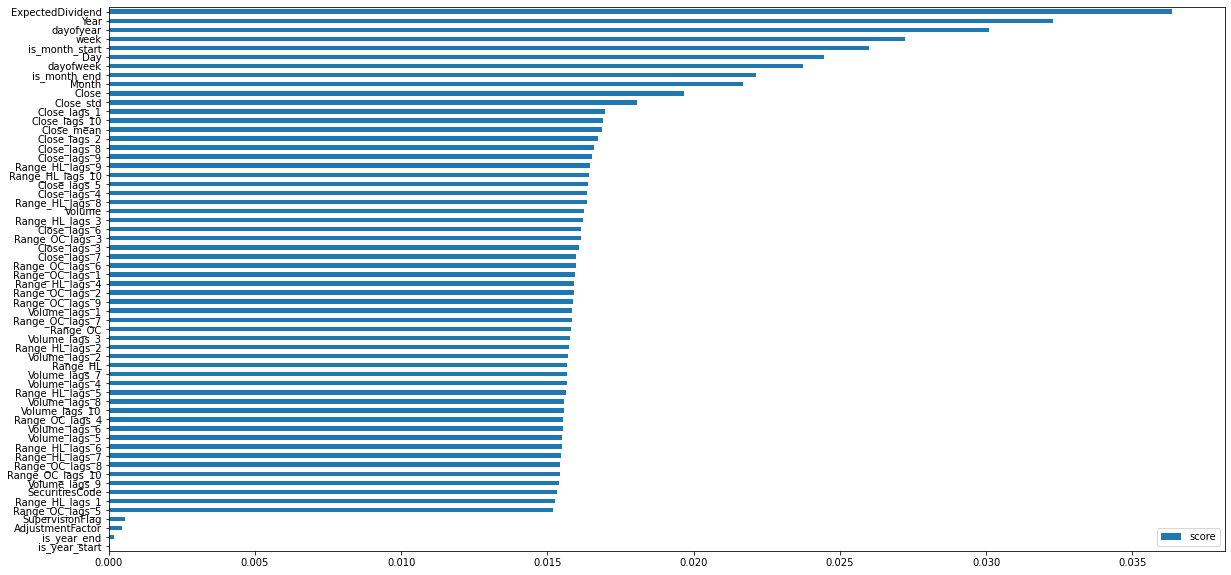

In [92]:
sorted_idx = np.argsort(mean_fi.values)[::-1]

data = pd.DataFrame(data=mean_fi.values[sorted_idx], index= mean_fi.keys()[sorted_idx], columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh', figsize = (20,10))

In [93]:
import seaborn as sb

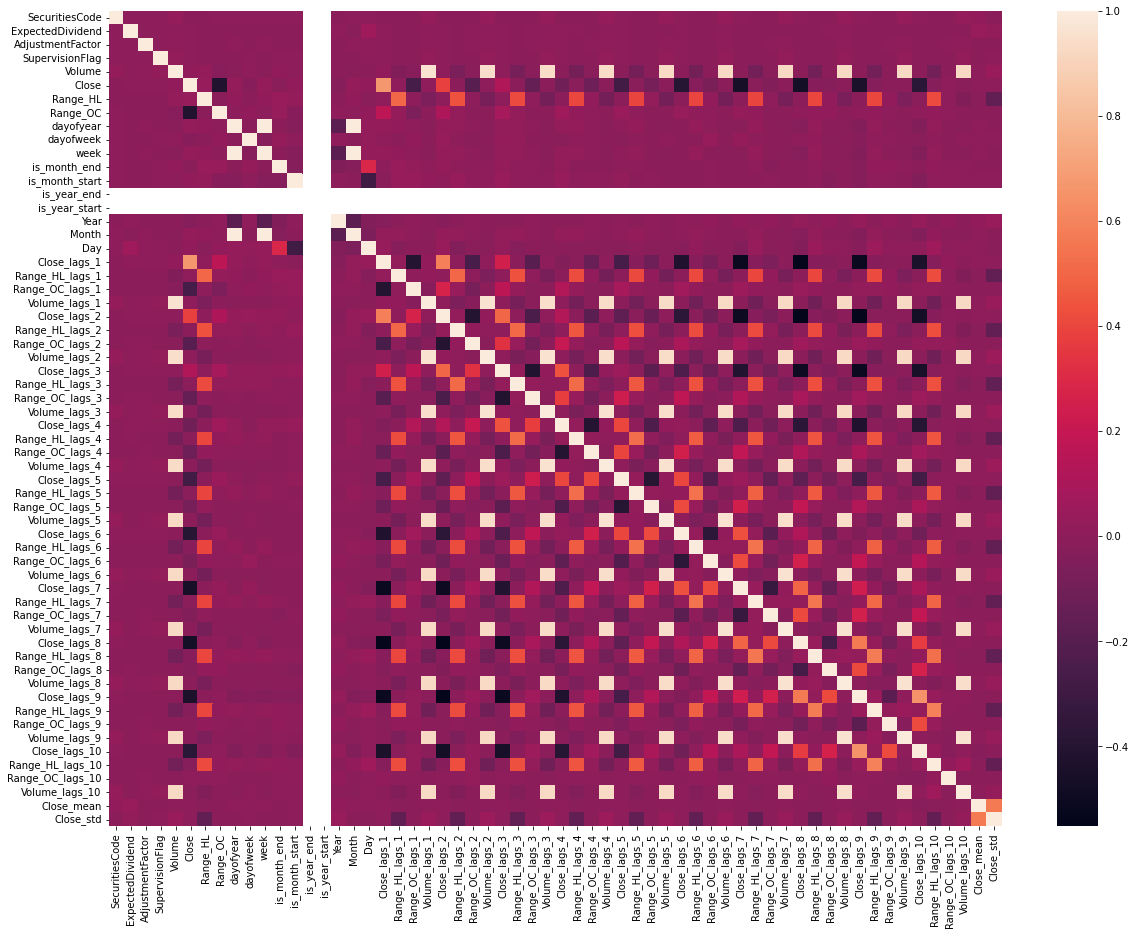

In [94]:
corr_matrix = train_df.sort_values(by=['SecuritiesCode', 'Date'])[list(featureCols)].corr()
plt.subplots(figsize=(20,15))
sb.heatmap(corr_matrix)

In [95]:
corr_matrix

,SecuritiesCode,ExpectedDividend,AdjustmentFactor,SupervisionFlag,Volume,Close,Range_HL,Range_OC,dayofyear,dayofweek,...,Close_lags_9,Range_HL_lags_9,Range_OC_lags_9,Volume_lags_9,Close_lags_10,Range_HL_lags_10,Range_OC_lags_10,Volume_lags_10,Close_mean,Close_std
SecuritiesCode,1.000000,0.002623,0.001960,0.002633,0.028462,-0.005547,-0.004829,-0.000278,-0.000104,-0.000021,...,0.004667,-0.005271,-0.001250,0.028592,0.005154,-0.005453,-0.001664,0.028631,0.017003,-0.012331
ExpectedDividend,0.002623,1.000000,-0.000477,-0.000392,0.003012,0.003830,-0.004796,-0.002940,-0.011068,-0.010812,...,-0.005862,-0.005172,-0.009788,-0.001139,-0.009263,-0.008259,-0.002540,-0.001696,0.039690,0.018228
AdjustmentFactor,0.001960,-0.000477,1.000000,-0.000102,0.009796,0.005192,-0.001189,-0.003683,0.007863,-0.006351,...,-0.006449,-0.002005,-0.000411,0.008852,-0.004164,-0.002037,0.000147,0.007844,-0.007641,-0.005131
SupervisionFlag,0.002633,-0.000392,-0.000102,1.000000,0.022104,0.002867,-0.002333,-0.001386,-0.002271,-0.000152,...,-0.002803,-0.002646,-0.001386,0.020588,-0.003208,-0.002453,-0.001619,0.020495,-0.005238,-0.000247
Volume,0.028462,0.003012,0.009796,0.022104,1.000000,0.016511,0.025582,-0.019301,-0.015730,0.007150,...,-0.009638,-0.095927,-0.011819,0.923466,-0.009077,-0.091508,-0.012636,0.922290,-0.000277,0.043285
Close,-0.005547,0.003830,0.005192,0.002867,0.016511,1.000000,0.033786,-0.417304,0.028425,-0.019783,...,-0.441501,-0.024910,-0.004657,-0.012348,-0.377463,-0.027190,0.009704,-0.013577,0.005509,0.000554
Range_HL,-0.004829,-0.004796,-0.001189,-0.002333,0.025582,0.033786,1.000000,-0.008772,0.015859,-0.004809,...,-0.011146,0.405632,0.013398,-0.059816,-0.015292,0.416762,0.002070,-0.046381,-0.015696,-0.158295
Range_OC,-0.000278,-0.002940,-0.003683,-0.001386,-0.019301,-0.417304,-0.008772,1.000000,0.001024,0.015192,...,0.008332,0.016487,0.001147,-0.006985,0.011568,0.015150,0.009892,-0.007604,-0.001474,-0.005469
dayofyear,-0.000104,-0.011068,0.007863,-0.002271,-0.015730,0.028425,0.015859,0.001024,1.000000,-0.010519,...,-0.035713,0.023084,-0.008486,-0.013503,-0.040947,0.021148,-0.007819,-0.014419,0.008986,-0.005860
dayofweek,-0.000021,-0.010812,-0.006351,-0.000152,0.007150,-0.019783,-0.004809,0.015192,-0.010519,1.000000,...,-0.022615,0.007763,0.000280,-0.001865,-0.013409,0.009328,-0.004142,0.008145,0.000272,-0.000419


In [96]:
_r, _c = np.where(np.abs(corr_matrix) > 0.8)

In [97]:
np.array(corr_matrix)[1, 25]

0.0014382957580065829

In [98]:
np.array([_r[np.where(_r != _c)[0]], _c[np.where(_r != _c)[0]]]).T

array([[ 4, 21],
       [ 4, 25],
       [ 4, 29],
       [ 4, 33],
       [ 4, 37],
       [ 4, 41],
       [ 4, 45],
       [ 4, 49],
       [ 4, 53],
       [ 4, 57],
       [ 8, 10],
       [ 8, 16],
       [10,  8],
       [10, 16],
       [16,  8],
       [16, 10],
       [21,  4],
       [21, 25],
       [21, 29],
       [21, 33],
       [21, 37],
       [21, 41],
       [21, 45],
       [21, 49],
       [21, 53],
       [21, 57],
       [25,  4],
       [25, 21],
       [25, 29],
       [25, 33],
       [25, 37],
       [25, 41],
       [25, 45],
       [25, 49],
       [25, 53],
       [25, 57],
       [29,  4],
       [29, 21],
       [29, 25],
       [29, 33],
       [29, 37],
       [29, 41],
       [29, 45],
       [29, 49],
       [29, 53],
       [29, 57],
       [33,  4],
       [33, 21],
       [33, 25],
       [33, 29],
       [33, 37],
       [33, 41],
       [33, 45],
       [33, 49],
       [33, 53],
       [33, 57],
       [37,  4],
       [37, 21],
       [37, 25

In [99]:
_r

array([ 0,  1,  2,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  6,
        7,  8,  8,  8,  9, 10, 10, 10, 11, 12, 15, 16, 16, 16, 17, 18, 19,
       20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 23, 24, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 27, 28, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 30, 31, 32, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 34, 35, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
       38, 39, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 43, 44,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 47, 48, 49, 49, 49,
       49, 49, 49, 49, 49, 49, 49, 49, 50, 51, 52, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 54, 55, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57,
       57, 57, 58, 59])

In [100]:
couple_feat_found = np.array([
    featureCols[1:][_r[np.where(_r != _c)[0]]], 
    featureCols[1:][_c[np.where(_r != _c)[0]]]
]).T
couple_feat_found

array([['Volume', 'Volume_lags_1'],
       ['Volume', 'Volume_lags_2'],
       ['Volume', 'Volume_lags_3'],
       ['Volume', 'Volume_lags_4'],
       ['Volume', 'Volume_lags_5'],
       ['Volume', 'Volume_lags_6'],
       ['Volume', 'Volume_lags_7'],
       ['Volume', 'Volume_lags_8'],
       ['Volume', 'Volume_lags_9'],
       ['Volume', 'Volume_lags_10'],
       ['dayofyear', 'week'],
       ['dayofyear', 'Month'],
       ['week', 'dayofyear'],
       ['week', 'Month'],
       ['Month', 'dayofyear'],
       ['Month', 'week'],
       ['Volume_lags_1', 'Volume'],
       ['Volume_lags_1', 'Volume_lags_2'],
       ['Volume_lags_1', 'Volume_lags_3'],
       ['Volume_lags_1', 'Volume_lags_4'],
       ['Volume_lags_1', 'Volume_lags_5'],
       ['Volume_lags_1', 'Volume_lags_6'],
       ['Volume_lags_1', 'Volume_lags_7'],
       ['Volume_lags_1', 'Volume_lags_8'],
       ['Volume_lags_1', 'Volume_lags_9'],
       ['Volume_lags_1', 'Volume_lags_10'],
       ['Volume_lags_2', 'Volume'],
     

In [101]:
corr_matrix[couple_feat_found[0][0]][couple_feat_found[0][1]]

0.9593553233350313

#### feature selection

In [102]:
feature_important_list = pd.read_csv('./result_feature_important.csv')

In [103]:
feature_important_list

,SecuritiesCode,ExpectedDividend,AdjustmentFactor,SupervisionFlag,Volume,Close,Range_HL,Range_OC,dayofyear,dayofweek,...,Close_lags_9,Range_HL_lags_9,Range_OC_lags_9,Volume_lags_9,Close_lags_10,Range_HL_lags_10,Range_OC_lags_10,Volume_lags_10,Close_mean,Close_std
0,0.015545,0.033659,0.000000,0.000000,0.015228,0.019462,0.014854,0.015013,0.031799,0.023935,...,0.015892,0.016489,0.015570,0.015211,0.016094,0.016401,0.015497,0.015425,0.016233,0.016820
1,0.015390,0.032320,0.000000,0.000000,0.016925,0.018637,0.015328,0.016097,0.031412,0.025787,...,0.016282,0.016721,0.015571,0.015865,0.017901,0.015926,0.014890,0.016232,0.016825,0.018817
2,0.014442,0.040623,0.000000,0.000000,0.016008,0.018706,0.015768,0.015636,0.031542,0.022150,...,0.016386,0.016038,0.016062,0.015182,0.017189,0.015873,0.015285,0.014678,0.016345,0.017652
3,0.012114,0.030879,0.000000,0.000000,0.015686,0.034001,0.015459,0.012475,0.042796,0.028147,...,0.020160,0.017908,0.015834,0.012364,0.018847,0.017091,0.012686,0.010076,0.015709,0.013861
4,0.015658,0.021891,0.000720,0.003221,0.017173,0.018679,0.016667,0.016067,0.025494,0.022756,...,0.016224,0.017825,0.017324,0.015860,0.017599,0.016901,0.016363,0.015731,0.018407,0.017274
5,0.016614,0.026587,0.000000,0.000000,0.016266,0.022155,0.016731,0.016235,0.031993,0.021493,...,0.018074,0.016603,0.017938,0.014542,0.017510,0.017300,0.016095,0.014683,0.017150,0.019664
6,0.013100,0.078304,0.000000,0.000588,0.015293,0.017743,0.015266,0.014982,0.030447,0.024944,...,0.014755,0.015019,0.015315,0.015573,0.016078,0.015138,0.014892,0.014924,0.016549,0.016346
7,0.015984,0.072230,0.000000,0.000000,0.015714,0.017809,0.014471,0.015057,0.024662,0.020681,...,0.015483,0.014874,0.015046,0.014901,0.015811,0.016422,0.015118,0.016044,0.016398,0.017434
8,0.014812,0.019156,0.000000,0.000000,0.018737,0.019371,0.015574,0.016370,0.026883,0.024028,...,0.016838,0.016194,0.015936,0.017301,0.014986,0.019484,0.015208,0.017846,0.019156,0.018033
9,0.017103,0.017962,0.000093,0.000000,0.016128,0.018887,0.017276,0.016159,0.026645,0.024980,...,0.017557,0.017249,0.016915,0.015942,0.017870,0.017831,0.017315,0.016619,0.018026,0.017390


In [104]:
mean_fi = feature_important_list.mean(axis= 0)
mean_fi

SecuritiesCode      0.015334
ExpectedDividend    0.036340
AdjustmentFactor    0.000465
SupervisionFlag     0.000563
Volume              0.016260
Close               0.019656
Range_HL            0.015679
Range_OC            0.015814
dayofyear           0.030090
dayofweek           0.023726
week                0.027233
is_month_end        0.022127
is_month_start      0.026002
is_year_end         0.000191
is_year_start       0.000043
Year                0.032291
Month               0.021677
Day                 0.024456
Close_lags_1        0.016983
Range_HL_lags_1     0.015249
Range_OC_lags_1     0.015948
Volume_lags_1       0.015854
Close_lags_2        0.016733
Range_HL_lags_2     0.015746
Range_OC_lags_2     0.015901
Volume_lags_2       0.015704
Close_lags_3        0.016075
Range_HL_lags_3     0.016201
Range_OC_lags_3     0.016135
Volume_lags_3       0.015788
Close_lags_4        0.016342
Range_HL_lags_4     0.015908
Range_OC_lags_4     0.015540
Volume_lags_4       0.015654
Close_lags_5  

In [105]:
mean_fi.values

array([1.53343250e-02, 3.63404719e-02, 4.64907655e-04, 5.63196965e-04,
       1.62595977e-02, 1.96561228e-02, 1.56785754e-02, 1.58142197e-02,
       3.00899989e-02, 2.37261395e-02, 2.72328242e-02, 2.21266716e-02,
       2.60020530e-02, 1.91278962e-04, 4.28821280e-05, 3.22910889e-02,
       2.16765597e-02, 2.44557978e-02, 1.69834715e-02, 1.52487678e-02,
       1.59478914e-02, 1.58538913e-02, 1.67331256e-02, 1.57460348e-02,
       1.59006230e-02, 1.57038515e-02, 1.60753703e-02, 1.62013144e-02,
       1.61350284e-02, 1.57876638e-02, 1.63423087e-02, 1.59077653e-02,
       1.55399020e-02, 1.56540045e-02, 1.63719887e-02, 1.56522606e-02,
       1.51908647e-02, 1.55143396e-02, 1.61571385e-02, 1.55056684e-02,
       1.59872916e-02, 1.55332437e-02, 1.59907153e-02, 1.54672280e-02,
       1.58403986e-02, 1.56776078e-02, 1.65831407e-02, 1.63411878e-02,
       1.54433813e-02, 1.55580384e-02, 1.65311784e-02, 1.64570594e-02,
       1.58589168e-02, 1.53827708e-02, 1.69092655e-02, 1.64119614e-02,
      

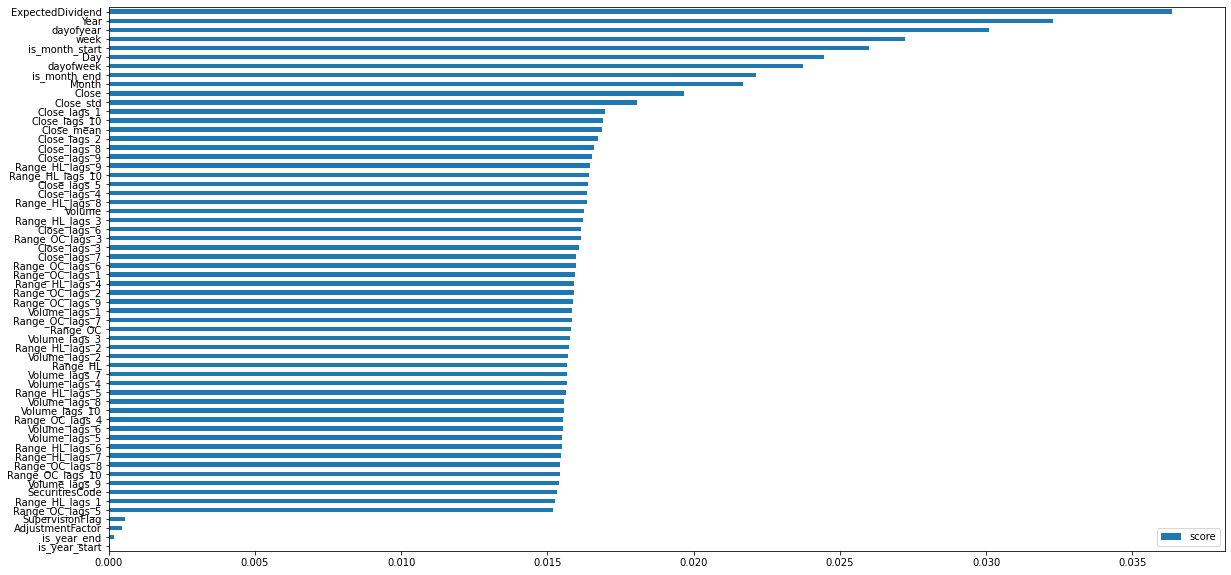

In [106]:
sorted_idx = np.argsort(mean_fi.values)[::-1]

data = pd.DataFrame(data=mean_fi.values[sorted_idx], index= mean_fi.keys()[sorted_idx], columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh', figsize = (20,10))

In [107]:
def FeaturesSelection(_df: pd.DataFrame, _fi: pd.Series, N_top: int):
    df = _df.copy()
    fi = _fi.copy()

    keys_drop_date = fi[['dayofyear', 'week', 'Month']].sort_values().keys()[:2]
    df.drop(
        keys_drop_date,
        axis = 1,
        inplace= True
    )
    fi.drop(keys_drop_date, inplace= True)

    keys_drop_top_volume = fi[['Volume_' + 'lags_' + str(i + 1) for i in range(int(N_past / 2))]].sort_values().keys()[ : int(N_past / 2) - 1]
    df.drop(
        keys_drop_top_volume,
        axis = 1,
        inplace= True
    )
    fi.drop(keys_drop_top_volume, inplace= True)

    keys_drop_bot_volume = fi[['Volume_' + 'lags_' + str(i + 1) for i in range(int(N_past / 2), N_past, 1)]].sort_values().keys()[ : N_past - int(N_past / 2) - 1]
    df.drop(
        keys_drop_bot_volume,
        axis = 1,
        inplace= True
    )
    fi.drop(keys_drop_bot_volume, inplace= True)

    df = df[list(fi.sort_values(ascending= False).keys()[: N_top]) + ['Date', 'Target', 'CloseT1', 'CloseT2']]
    return df

In [118]:
train_df_N = FeaturesSelection(train_df, mean_fi, 30)
valid_df_N = FeaturesSelection(valid_df, mean_fi, 30)
test_df_N = FeaturesSelection(test_df, mean_fi, 30)

In [119]:
train_df_N.info(null_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1843182 entries, 0 to 1843181
Data columns (total 34 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   ExpectedDividend  1843182 non-null  float64       
 1   Year              1843182 non-null  int64         
 2   dayofyear         1843182 non-null  int64         
 3   is_month_start    1843182 non-null  bool          
 4   Day               1843182 non-null  int64         
 5   dayofweek         1843182 non-null  int64         
 6   is_month_end      1843182 non-null  bool          
 7   Close             1843182 non-null  float64       
 8   Close_std         1843182 non-null  float64       
 9   Close_lags_1      1843182 non-null  float64       
 10  Close_lags_10     1843182 non-null  float64       
 11  Close_mean        1843182 non-null  float64       
 12  Close_lags_2      1843182 non-null  float64       
 13  Close_lags_8      1843182 non-null  float6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [120]:
valid_df_N.info(null_counts= True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232663 entries, 0 to 232662
Data columns (total 34 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ExpectedDividend  232663 non-null  float64       
 1   Year              232663 non-null  int64         
 2   dayofyear         232663 non-null  int64         
 3   is_month_start    232663 non-null  bool          
 4   Day               232663 non-null  int64         
 5   dayofweek         232663 non-null  int64         
 6   is_month_end      232663 non-null  bool          
 7   Close             232663 non-null  float64       
 8   Close_std         232663 non-null  float64       
 9   Close_lags_1      232663 non-null  float64       
 10  Close_lags_10     232663 non-null  float64       
 11  Close_mean        232663 non-null  float64       
 12  Close_lags_2      232663 non-null  float64       
 13  Close_lags_8      232663 non-null  float64       
 14  Clos

In [121]:
test_df_N.info(null_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198663 entries, 0 to 198662
Data columns (total 34 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ExpectedDividend  198663 non-null  float64       
 1   Year              198663 non-null  int64         
 2   dayofyear         198663 non-null  int64         
 3   is_month_start    198663 non-null  bool          
 4   Day               198663 non-null  int64         
 5   dayofweek         198663 non-null  int64         
 6   is_month_end      198663 non-null  bool          
 7   Close             198663 non-null  float64       
 8   Close_std         198663 non-null  float64       
 9   Close_lags_1      198663 non-null  float64       
 10  Close_lags_10     198663 non-null  float64       
 11  Close_mean        198663 non-null  float64       
 12  Close_lags_2      198663 non-null  float64       
 13  Close_lags_8      198663 non-null  float64       
 14  Clos

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [122]:
train_df_N.to_csv('../__input__/3_FeatureSelection/train_full.csv', index = False)
valid_df_N.to_csv('../__input__/3_FeatureSelection/valid_full.csv', index = False)
test_df_N.to_csv('../__input__/3_FeatureSelection/test_full.csv', index = False)